# World Data League 2022

Determining the mobility flow in the city of Lisbon based on mobile phone data


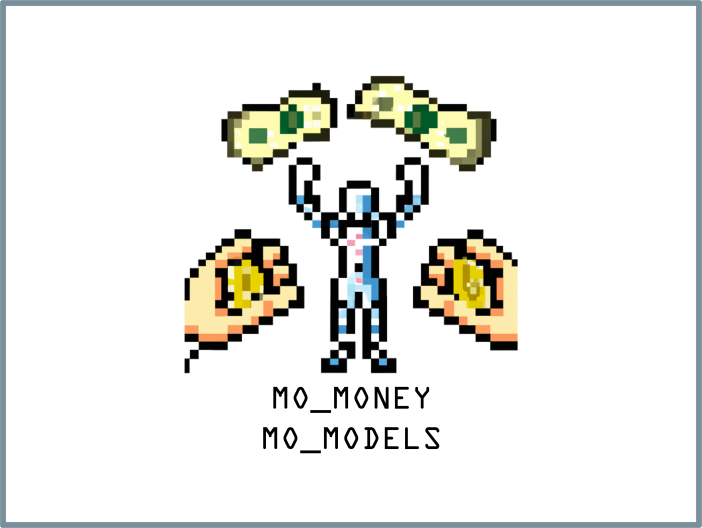
## Team: Mo Money, Mo Models
## 👥 Authors
* David Raposo
* Duarte Pereira
* Martim Chaves
* Paulo Sousa

## 💻 Development

## Introduction
Have you ever found yourself in a crowded area where it's difficult to move around, or perhaps in a situation where there are too many people in one place and it becomes uncomfortable or unsafe? Our CNN-LSTM model for forecasting phone distribution could be the solution you need within the city of Lisbon! The current metro area population of Lisbon in 2023 is 3,001,000, a 0.5% increase from 2022, which brings a high risk of overcrowding. [1]

Although we encountered some challenges with training time and had to limit the learning rate, epochs, and batch size, we believe this model can have a significant impact on the city of Lisbon. By leveraging the data from phone towers in Lisbon, this model can detect areas with increased people flow and alert city managers, detecting and preventing overcrowding situations before they occur.

We are continually improving this model and plan to add more data sources, such as train station/route data and climate data, to make it even more accurate and effective. Our goal is to apply this model to other cities and regions around the world, potentially even beyond city planning and management, as it has a wide range of potential applications.

`NOTE FOR THE TECHNICAL EVALUATION:` As we develop the code in separate notebooks, it may not runnable. Hence, here's our github repository: https://github.com/duarteoliper/WDL_2023

As such, we performed the following tasks:
* 📱 Phone Grid Dataset
    * Exploratory Analysis
    * Cleaning
* ⚙️ Modelling
    * Preliminary Preprocessing
    * CNN-LSTM
* 🚇 Train Station Dataset - Exploratory Analysis & Proof-of-Concept

### **TODO** 📱 Phone Grid Dataset - Exploratory Analysis and data cleaning
The phone grid dataset constitutes a valuable indicator for people's movement within the city of Lisbon. It contains variables representing phones staying, exiting, and entering grids, as well as which of those are in roaming. 

We performed exploratory analysis and cleaning tasks, including dealing with missing values and outliers.

WARNING: this EDA was not yet applied to the modelling stage due to submission time constraints

In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm import tqdm
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt

* Reading the Data

* Feature Data

In [ ]:
def read_df_movs():
    # Data file names
    grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")

    #There are mov files for different datas, I'll add all of them here latter 
    movs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_GRELHA E EIXOS")
    movs_2022_09 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv")
    movs_2022_10 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_10_0001_4000.csv")
    movs_2022_11 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv")

    # Read data of each month
    df_movs_2022_09= pd.read_csv(movs_2022_09, parse_dates=["Datetime"])
    df_movs_2022_10= pd.read_csv(movs_2022_10, parse_dates=["Datetime"])
    df_movs_2022_11= pd.read_csv(movs_2022_11, parse_dates=["Datetime"])

    # Join the 3 months' dataframes:
    df_movs = pd.concat([df_movs_2022_09, df_movs_2022_10, df_movs_2022_11])
    del(df_movs_2022_09, df_movs_2022_10, df_movs_2022_11)

    # Order by date and reset index
    df_movs = df_movs.sort_values(by=['Grid_ID', 'Datetime']).reset_index(drop=True)

    return df_movs

In [ ]:
df_movs = read_df_movs()

* Grid Info Data

In [ ]:
# Read data from the xlsx file
grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
grid_geometry = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

In [ ]:
# Function to remove extra curly braces and return a valid WKT string
def fix_wkt_string(wkt_string):
    return wkt_string.replace("{{{", "(((").replace("}}}", ")))")

In [ ]:
# Remove extra curly braces
grid_geometry["wkt"] = grid_geometry["wkt"].apply(fix_wkt_string)

In [ ]:
grid_geometry['geometry'] = grid_geometry['wkt'].apply(wkt.loads)

In [ ]:
grid_gdf = gpd.GeoDataFrame(grid_geometry, geometry='geometry')

In [ ]:
# create a dictionary of column name mappings
column_names = {'grelha_id': 'Grid_ID'}

# rename the grid_id column name using the dictionary
grid_gdf = grid_gdf.rename(columns=column_names)

* Analysis of the Missing Values

In [ ]:
# count missing values in each column
print(df_movs.isna().sum())

Grid_ID     0
Datetime    0
C1          0
C2          0
C3          0
C4          0
C5          0
C6          0
C7          0
C8          0
dtype: int64


No missing values.

* Analysis of Duplicate Values

In [ ]:
df_movs

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8
0,1,2022-09-07 12:30:00+00:00,3.690000,0.00,3.69,0.00,0.00,5.28,0.0,0.00
1,1,2022-09-07 22:30:00+00:00,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.00
2,1,2022-09-07 23:00:00+00:00,0.000000,0.00,0.00,0.00,0.00,0.00,0.0,0.00
3,1,2022-09-07 18:00:00+00:00,15.720000,0.00,10.48,0.00,5.24,6.84,0.0,2.45
4,1,2022-09-07 06:30:00+00:00,3.860000,0.00,1.93,0.00,3.86,4.43,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
10216646,3743,2022-11-28 00:00:00+00:00,15.230000,0.00,15.23,0.00,4.28,16.07,0.0,0.00
10216647,3743,2022-11-28 01:45:00+00:00,19.059999,0.00,15.95,0.00,3.12,8.04,0.0,0.00
10216648,3743,2022-11-28 03:45:00+00:00,9.890000,0.00,9.89,0.00,0.00,6.85,0.0,0.00
10216649,3743,2022-11-30 05:45:00+00:00,15.440000,5.46,10.45,5.46,4.99,7.13,0.0,0.00


In [ ]:
duplicates = df_movs.duplicated()
num_duplicates = duplicates.sum()
print(f'Number of duplicate rows: {num_duplicates}')

Number of duplicate rows: 0


No duplicate values were found, which is good!

* Consistency of the Data/Measurements

Let's start by checking if, for each Grid_ID, there's the same start and end data, and the same number of data points (rows).

In [ ]:
# Group by Grid_ID
grid_id_grouped = df_movs.groupby('Grid_ID')

In [ ]:
# if you need extra memory
del df_movs
gc.collect()

In [ ]:
# Checking the min and max dates for each Grid_ID
start_dates = grid_id_grouped['Datetime'].min()
end_dates = grid_id_grouped['Datetime'].max()

# Checking if the start and end dates are the same for all Grid_IDs
all_start_dates_same = start_dates.nunique() == 1
all_end_dates_same = end_dates.nunique() == 1

# Checking the number of rows for each Grid_ID
num_rows = grid_id_grouped.size()

# Checking if the number of rows is the same for all Grid_IDs
all_num_rows_same = num_rows.nunique() == 1

# Printing the results
print("All start dates are the same:", all_start_dates_same)
print("All end dates are the same:", all_end_dates_same)
print("All number of rows are the same:", all_num_rows_same)

All start dates are the same: True
All end dates are the same: True
All number of rows are the same: False


It seems that the number of measurements are not the same for all Grid_IDs. This is something that we need to fix, so that there's data for every grid square every 15 minutes. Let's look at how many rows of data we should have for each Grid_ID.

In [ ]:
# Get the start and end dates for all Grid_IDs (we know they're the same)
start_date = grid_id_grouped['Datetime'].min().iloc[0]
end_date = grid_id_grouped['Datetime'].max().iloc[0]

# Calculate the time delta and convert it to minutes
time_delta = end_date - start_date
time_delta_minutes = time_delta.total_seconds() / 60

# Calculate the expected number of rows
interval_minutes = 15
expected_num_rows = int(time_delta_minutes / interval_minutes) + 1  # Add 1 to account for the first measurement

print("Expected number of rows:", expected_num_rows)

Expected number of rows: 8736


Let's check what's the most common number of rows, and how many Grid_IDs have less rows than expected.

In [ ]:
# Find the mode (most common number of rows)
mode_rows = num_rows.mode()[0]

# Find Grid_IDs with a different number of rows than the expected
deviating_grid_ids = num_rows[num_rows != 8736]

# Print the results
print(f"Most common number of rows: {mode_rows}")
print("Grid_IDs deviating from the most common row count:")
print(deviating_grid_ids)

Most common number of rows: 8251
Grid_IDs deviating from the most common row count:
Grid_ID
1       8251
2       8251
3       8252
4       8252
5       8251
        ... 
3739    8250
3740    8252
3741    8250
3742    8251
3743    8250
Length: 3743, dtype: int64


It seems that every Grid_ID does not have the expected number of rows. Let's plot a histogram to have an idea of how the number of rows per Grid_ID is distributed.

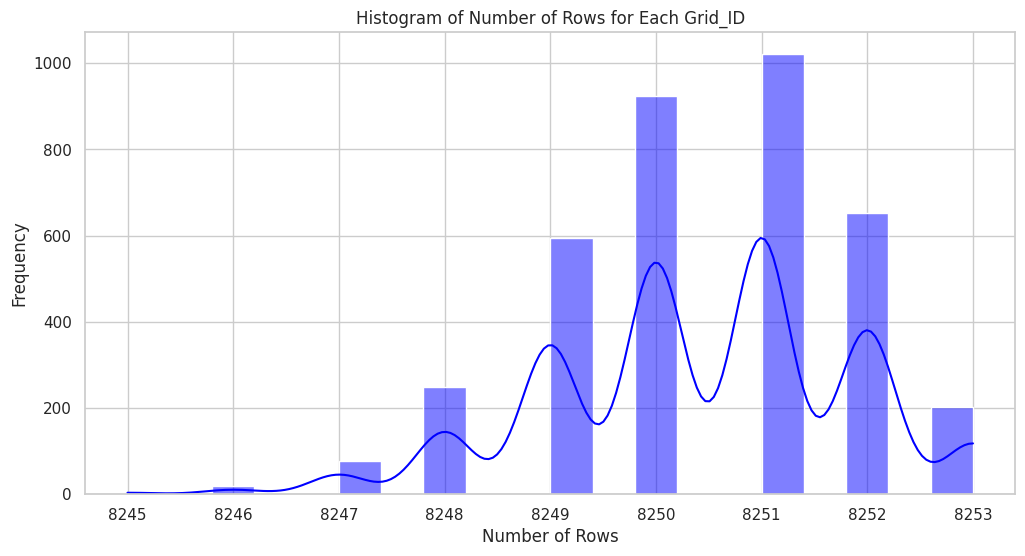

In [ ]:
# Need to reset the index
num_rows_ind_rest = num_rows.reset_index(name='Row_Count')

# Create a histogram using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
hist_plot = sns.histplot(data=num_rows_ind_rest, x='Row_Count', kde=True, color='blue', bins=20)
hist_plot.set(xlabel='Number of Rows', ylabel='Frequency', title='Histogram of Number of Rows for Each Grid_ID')

plt.show()

Interesting, it seems that there is a pattern to the data that we have. Most have around 8250 rows of data. Perhaps there is a specific moment in time where data was not collected? Let's check for that. We'll calculate time gaps between consecutive measurements for each Grid_ID, and check if there is a pattern to large gaps. If there is, we may be looking at a moment in time when no measurements were being made. Otherwise, it may just be random data loss. We'll deal with this issue differently depending on the cause of it.

In [ ]:
# Function to calculate time gaps for each Grid_ID
def analyze_time_gaps(group):
    group = group.sort_values('Datetime')
    # compare Datetime with previous Datetime
    group['Time_Gap'] = group['Datetime'].diff()
    return group

In [ ]:
# Apply the function to each group and concatenate the results
gaps_df = grid_id_grouped.apply(analyze_time_gaps)

In [ ]:
gaps_df.head()

Grid_ID                  Datetime    C1   C2   C3   C4    C5    C6   
Grid_ID                                                                         
1       0        1 2022-09-01 00:00:00+00:00  0.00  0.0  0.0  0.0  0.00  0.00  \
        1        1 2022-09-01 00:15:00+00:00  0.00  0.0  0.0  0.0  0.00  0.00   
        2        1 2022-09-01 00:30:00+00:00  6.66  0.0  0.0  0.0  6.66  5.13   
        3        1 2022-09-01 00:45:00+00:00  0.00  0.0  0.0  0.0  0.00  0.00   
        4        1 2022-09-01 01:00:00+00:00  0.00  0.0  0.0  0.0  0.00  0.00   

            C7   C8        Time_Gap  
Grid_ID                              
1       0  0.0  0.0             NaT  
        1  0.0  0.0 0 days 00:15:00  
        2  0.0  0.0 0 days 00:15:00  
        3  0.0  0.0 0 days 00:15:00  
        4  0.0  0.0 0 days 00:15:00

In [ ]:
# Calculate the time gaps larger than 15 minutes
larger_gaps = gaps_df[gaps_df['Time_Gap'] > pd.Timedelta(minutes=15)]

In [ ]:
larger_gaps.iloc[0:20]

Grid_ID                  Datetime     C1     C2     C3    C4   
Grid_ID                                                                       
1       1356         1 2022-09-15 15:00:00+00:00   1.38   1.38   1.38  1.38  \
        4719         1 2022-10-20 20:15:00+00:00   9.97   9.97   0.00  0.00   
        4736         1 2022-10-21 11:45:00+00:00   0.00   0.00   0.00  0.00   
        4844         1 2022-10-22 15:15:00+00:00   0.00   0.00   0.00  0.00   
        5093         1 2022-10-25 06:00:00+00:00   0.00   0.00   0.00  0.00   
        5125         1 2022-10-26 13:00:00+00:00   0.00   0.00   0.00  0.00   
        5470         1 2022-10-31 11:15:00+00:00   0.00   0.00   0.00  0.00   
        6422         1 2022-11-10 09:30:00+00:00   0.00   0.00   0.00  0.00   
        6427         1 2022-11-10 11:00:00+00:00  34.98   0.00  34.98  0.00   
        7118         1 2022-11-17 17:15:00+00:00   3.19   0.00   3.19  0.00   
        7147         1 2022-11-18 00:45:00+00:00   0.00   0.00   0.00  0.00   
        7199         1 2022-11-18 14:45:00+00:00   0.00   0.00   0.00  0.00   
        7328         1 2022-11-21 09:15:00+00:00   0.00   0.00   0.00  0.00   
2       9607         2 2022-09-15 15:00:00+00:00   7.30   0.00   3.92  0.00   
        12970        2 2022-10-20 20:15:00+00:00   0.00   0.00   0.00  0.00   
        12987        2 2022-10-21 11:45:00+00:00   0.00   0.00   0.00  0.00   
        13095        2 2022-10-22 15:15:00+00:00  13.06  13.06   0.00  0.00   
        13344        2 2022-10-25 06:00:00+00:00   0.00   0.00   0.00  0.00   
        13376        2 2022-10-26 13:00:00+00:00   0.00   0.00   0.00  0.00   
        13721        2 2022-10-31 11:15:00+00:00  10.91   0.00  10.91  0.00   

                  C5    C6     C7    C8        Time_Gap  
Grid_ID                                                  
1       1356    0.00  0.00   0.00  0.00 0 days 12:15:00  
        4719    9.97  9.97   9.97  9.97 0 days 04:45:00  
        4736    0.00  0.00   0.00  0.00 0 days 11:30:00  
        4844    0.00  0.00   0.00  0.00 0 days 00:45:00  
        5093    0.00  0.00   0.00  0.00 0 days 00:45:00  
        5125    0.00  0.00   0.00  0.00 0 days 23:15:00  
        5470    0.00  0.00   0.00  0.00 1 days 08:15:00  
        6422    0.00  0.00   0.00  0.00 0 days 00:30:00  
        6427    0.00  3.69   0.00  0.00 0 days 00:30:00  
        7118    3.19  0.00   0.00  0.00 0 days 01:45:00  
        7147    0.00  0.00   0.00  0.00 0 days 00:30:00  
        7199    0.00  0.00   0.00  0.00 0 days 01:15:00  
        7328    0.00  0.00   0.00  0.00 1 days 10:30:00  
2       9607    3.39  3.39   0.00  0.00 0 days 12:15:00  
        12970   0.00  0.00   0.00  0.00 0 days 04:45:00  
        12987   0.00  0.00   0.00  0.00 0 days 11:30:00  
        13095  13.06  6.95  13.06  6.95 0 days 00:45:00  
        13344   0.00  0.00   0.00  0.00 0 days 00:45:00  
        13376   0.00  0.00   0.00  0.00 0 days 23:15:00  
        13721   0.00  0.00   0.00  0.00 1 days 08:15:00

Visually comparing the gaps, it seems that they are consistent between Grid_IDs, i.e. there were moments when data was not being collected.

In [ ]:
# Analyze the frequency of larger gaps by Grid_ID
large_gaps_count = larger_gaps['Grid_ID'].value_counts()

In [ ]:
print("Grid_IDs with a higher frequency of larger time gaps:")
print(large_gaps_count)

Grid_IDs with a higher frequency of larger time gaps:
Grid_ID
435     17
72      17
143     17
395     17
648     17
        ..
2473    11
3239    11
3238    11
3237    11
875     11
Name: count, Length: 3743, dtype: int64


In [ ]:
# Check how many unique large gaps there are
large_gaps_count.unique()

array([17, 16, 15, 14, 13, 12, 11])

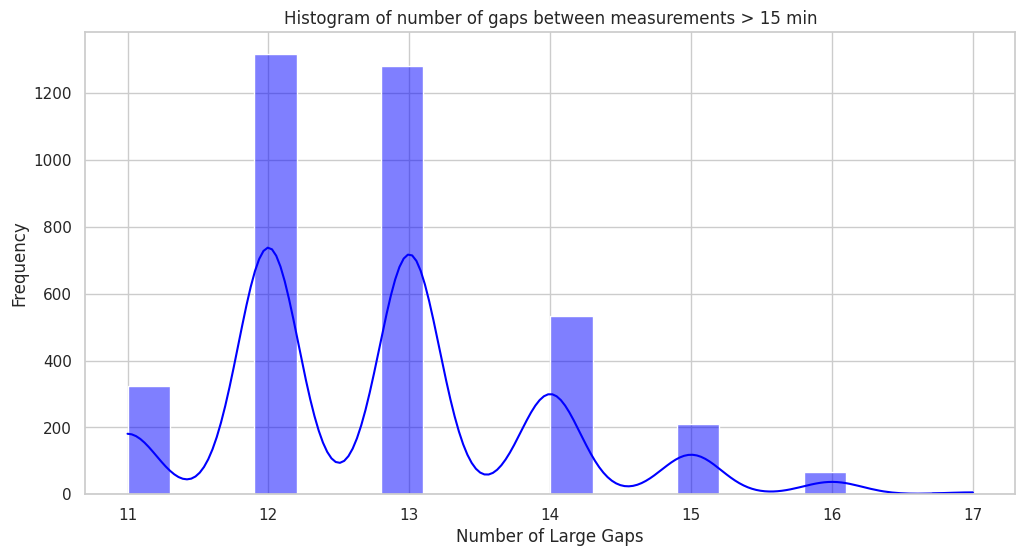

In [ ]:
# Need to reset the index
large_gaps_count_ind = large_gaps_count.reset_index(name='Large_Gap_Count')

# Create a histogram
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
hist_plot = sns.histplot(data=large_gaps_count_ind, x='Large_Gap_Count', kde=True, color='blue', bins=20)
hist_plot.set(xlabel='Number of Large Gaps', ylabel='Frequency', title='Histogram of number of gaps between measurements > 15 min')

plt.show()

There seems to be some consistency to number of large gaps accross different Grid_IDs.

In [ ]:
# Group the larger_gaps DataFrame by Datetime and count the number of Grid_IDs with a large gap at each timestamp
large_gap_timestamps = larger_gaps.groupby(['Datetime', 'Time_Gap'])['Grid_ID'].count()

In [ ]:
large_gap_timestamps.head()

Datetime                   Time_Gap       
2022-09-05 12:15:00+00:00  0 days 00:30:00      94
2022-09-15 15:00:00+00:00  0 days 12:15:00    3743
2022-10-04 12:15:00+00:00  0 days 00:30:00     403
2022-10-20 20:15:00+00:00  0 days 04:45:00    3743
2022-10-21 11:45:00+00:00  0 days 11:30:00    3743
Name: Grid_ID, dtype: int64

In [ ]:
# Sort the timestamps by the number of Grid_IDs with a large gap
large_gap_timestamps = large_gap_timestamps.sort_values(ascending=False)

In [ ]:
total_number_grids = larger_gaps["Grid_ID"].nunique()
print(total_number_grids)

3743


In [ ]:
print("Timestamps with consistent large gaps:")
print(large_gap_timestamps[large_gap_timestamps >= total_number_grids])

Timestamps with consistent large gaps:
Datetime                   Time_Gap       
2022-11-21 09:15:00+00:00  1 days 10:30:00    3743
2022-10-25 06:00:00+00:00  0 days 00:45:00    3743
2022-09-15 15:00:00+00:00  0 days 12:15:00    3743
2022-11-17 17:15:00+00:00  0 days 01:45:00    3743
2022-10-31 11:15:00+00:00  1 days 08:15:00    3743
2022-10-26 13:00:00+00:00  0 days 23:15:00    3743
2022-11-18 14:45:00+00:00  0 days 01:15:00    3743
2022-10-22 15:15:00+00:00  0 days 00:45:00    3743
2022-10-21 11:45:00+00:00  0 days 11:30:00    3743
2022-10-20 20:15:00+00:00  0 days 04:45:00    3743
Name: Grid_ID, dtype: int64


In [ ]:
print("Timestamps with INconsistent large gaps:")
print(large_gap_timestamps[large_gap_timestamps < total_number_grids])

Timestamps with INconsistent large gaps:
Datetime                   Time_Gap       
2022-11-10 11:00:00+00:00  0 days 00:30:00    2392
                           0 days 00:45:00    1351
2022-11-10 09:15:00+00:00  0 days 00:30:00     839
2022-11-10 10:15:00+00:00  0 days 00:30:00     809
2022-11-19 03:45:00+00:00  0 days 00:30:00     622
2022-11-10 09:45:00+00:00  0 days 00:30:00     560
2022-11-10 09:30:00+00:00  0 days 00:30:00     559
2022-11-18 00:45:00+00:00  0 days 00:30:00     557
2022-11-10 10:00:00+00:00  0 days 00:30:00     531
2022-10-04 12:15:00+00:00  0 days 00:30:00     403
2022-11-10 10:15:00+00:00  0 days 00:45:00     303
2022-11-10 09:30:00+00:00  0 days 00:45:00     299
2022-11-17 23:45:00+00:00  0 days 00:30:00     275
2022-11-10 08:30:00+00:00  0 days 00:30:00     224
2022-11-10 10:00:00+00:00  0 days 00:45:00     172
2022-11-10 09:45:00+00:00  0 days 00:45:00     161
2022-09-05 12:15:00+00:00  0 days 00:30:00      94
2022-11-10 09:45:00+00:00  0 days 01:00:00      9

It seems that there have been some moments where measurements were not made for all Grid_IDs. However, there were indeed moments when measurements were not made for some Grid_IDs only.

Knowing this, we can encapsulate the information about time of day, and day of the week by adding another feature. This will allow us to not have to add new data for moments were measurements were not done for all Grid_IDs, so that we don't add new, likely wrong data.

However, for the other moments, where only some Grid_IDs add issues, we need to add the missing values, since for these moments, the amount of Grid_IDs that do have data available are quite a few (2392 ~= 60% of all Grid_IDs, meaning the worst moment that didn't affect all Grid_IDs only affected around 60% of the Grid_IDs).

Let's create a chart to better understand what is going on.

In [ ]:
# Get DF by reseting index
large_gap_timestamps_df = large_gap_timestamps.reset_index()

# Convert the Time_Gap to minutes for better visualization
large_gap_timestamps_df['Time_Gap_Minutes'] = large_gap_timestamps_df['Time_Gap'].dt.total_seconds() / 60

In [ ]:
large_gap_timestamps_df.head()

,Datetime,Time_Gap,Grid_ID,Time_Gap_Minutes
0,2022-11-21 09:15:00+00:00,1 days 10:30:00,3743,2070.0
1,2022-10-25 06:00:00+00:00,0 days 00:45:00,3743,45.0
2,2022-09-15 15:00:00+00:00,0 days 12:15:00,3743,735.0
3,2022-11-17 17:15:00+00:00,0 days 01:45:00,3743,105.0
4,2022-10-31 11:15:00+00:00,1 days 08:15:00,3743,1935.0


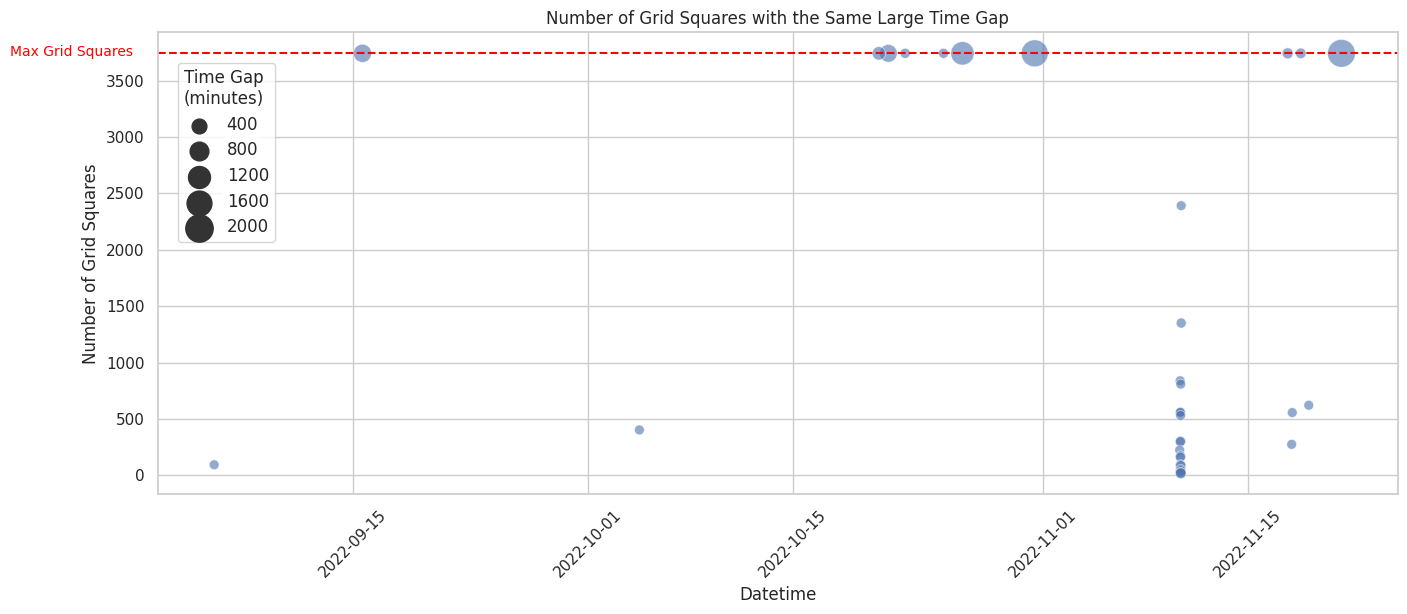

In [ ]:
# Create a scatter plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(16, 6))

scatter_plot = sns.scatterplot(data=large_gap_timestamps_df,
                               x='Datetime', y='Grid_ID', size='Time_Gap_Minutes',
                               sizes=(50, 400), alpha=0.6)
scatter_plot.set(xlabel='Datetime', ylabel='Number of Grid Squares',
                 title='Number of Grid Squares with the Same Large Time Gap')

# Add a horizontal dotted line equal to the maximum number of Grid_IDs
plt.axhline(y=total_number_grids, color='red', linestyle='--')
# Add a text annotation to the left of the y-axis
# Added - 20 to the y level so the text is centred
plt.annotate('Max Grid Squares', xy=(-0.02, total_number_grids - 20),
             xycoords=('axes fraction', 'data'), fontsize=10, color='red', ha='right')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust the size difference between scatter points
scatter_plot.legend(loc='upper left', title='Time Gap\n(minutes)')

# Modify the legend properties
leg = scatter_plot.legend_
leg.set_bbox_to_anchor([0.01, 0.95])  # Move the legend box to the desired position
leg._legend_box.align = "left"       # Align legend text to the left

# Set the fontsize and increase the size of the legend box
for text in leg.get_lines() + leg.get_texts():
    text.set_fontsize(12)
    text.set_bbox(dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2'))

plt.show()

From the above chart we can see that there are:
* Moments when no measurements were made (and in some of those moments, it took some time for measurements to be made again).
* A day where quite a few Grid Squares got affected but for slightly different moments (i.e. throughout the day different Grid Squares were affected at different times).
* Random moments where some Grid Squares did not have their data captured. 

Essentially though, for the moments when not all Grid Squares were affected at the same time, the **amount of time** they were affected for was **small** (we can see that via the size of the scatter points).

Given that, we can have some confidence that interpolating values for those moments will be OK.

Then, for the moments were there was no data for all Grid Squares, we don't have to add interpolated data, and instead we can add 3 new features to the dataset:
1. The day of the week
2. The hour
3. The minutes

This way we don't need to add large chunks of interpolated data, and we can help the model derive some sense of when the data was captured, to better understand the likely seasonality of the data.

In [ ]:
all_gridid_gaps = large_gap_timestamps_df[large_gap_timestamps_df['Grid_ID'] == total_number_grids][['Datetime', 'Time_Gap']]

In [ ]:
type(all_gridid_gaps["Datetime"][0])

pandas._libs.tslibs.timestamps.Timestamp

In [ ]:
type(all_gridid_gaps["Time_Gap"][0])

pandas._libs.tslibs.timedeltas.Timedelta

In [ ]:
all_gridid_gaps

,Datetime,Time_Gap
0,2022-11-21 09:15:00+00:00,1 days 10:30:00
1,2022-10-25 06:00:00+00:00,0 days 00:45:00
2,2022-09-15 15:00:00+00:00,0 days 12:15:00
3,2022-11-17 17:15:00+00:00,0 days 01:45:00
4,2022-10-31 11:15:00+00:00,1 days 08:15:00
5,2022-10-26 13:00:00+00:00,0 days 23:15:00
6,2022-11-18 14:45:00+00:00,0 days 01:15:00
7,2022-10-22 15:15:00+00:00,0 days 00:45:00
8,2022-10-21 11:45:00+00:00,0 days 11:30:00
9,2022-10-20 20:15:00+00:00,0 days 04:45:00


In [ ]:
all_gridid_gaps.to_csv("../data/interim/all_gridid_gaps.csv")

In [ ]:
del all_gridid_gaps
del gaps_df
del grid_id_grouped
del large_gap_timestamps
del large_gap_timestamps_df
del large_gaps_count
del large_gaps_count_ind
del larger_gaps

gc.collect()

32

In [ ]:
# the kernel may die, in that case, please restart it, and come back to this cell :)
df_movs = read_df_movs()

In [ ]:
df_movs.head()

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8
0,1,2022-09-01 00:00:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,1,2022-09-01 00:15:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,1,2022-09-01 00:30:00+00:00,6.66,0.0,0.0,0.0,6.66,5.13,0.0,0.0
3,1,2022-09-01 00:45:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
4,1,2022-09-01 01:00:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0


In [ ]:
all_gridid_gaps = pd.read_csv("../data/interim/all_gridid_gaps.csv")
all_gridid_gaps["Datetime"] = pd.to_datetime(all_gridid_gaps["Datetime"])
all_gridid_gaps["Time_Gap"] = pd.to_timedelta(all_gridid_gaps["Time_Gap"])

In [ ]:
# missing time stamps
# from those, remove time stamps in the all_gridid_gaps
    # extend the all_gridid_gaps
    # remove that from the time stamps
# add the missing time stamps to the df_movs
# fill in missing values with interpolation

In [ ]:
missing_time_stamps = pd.date_range(df_movs["Datetime"].min(), df_movs["Datetime"].max(), freq='15min')

In [ ]:
for _, row in all_gridid_gaps.iterrows():
    gap_end = row['Datetime']
    gap_duration = row['Time_Gap']
    gap_start = gap_end - gap_duration

    # Filter out the time steps that fall within this gap
    missing_time_stamps = missing_time_stamps[
        (missing_time_stamps <= gap_start) | (missing_time_stamps >= gap_end)
    ]

In [ ]:
missing_time_stamps

DatetimeIndex(['2022-09-01 00:00:00+00:00', '2022-09-01 00:15:00+00:00',
               '2022-09-01 00:30:00+00:00', '2022-09-01 00:45:00+00:00',
               '2022-09-01 01:00:00+00:00', '2022-09-01 01:15:00+00:00',
               '2022-09-01 01:30:00+00:00', '2022-09-01 01:45:00+00:00',
               '2022-09-01 02:00:00+00:00', '2022-09-01 02:15:00+00:00',
               ...
               '2022-11-30 21:30:00+00:00', '2022-11-30 21:45:00+00:00',
               '2022-11-30 22:00:00+00:00', '2022-11-30 22:15:00+00:00',
               '2022-11-30 22:30:00+00:00', '2022-11-30 22:45:00+00:00',
               '2022-11-30 23:00:00+00:00', '2022-11-30 23:15:00+00:00',
               '2022-11-30 23:30:00+00:00', '2022-11-30 23:45:00+00:00'],
              dtype='datetime64[ns, UTC]', length=8254, freq=None)

In [ ]:
df_movs.head()

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8
0,1,2022-09-01 00:00:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,1,2022-09-01 00:15:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,1,2022-09-01 00:30:00+00:00,6.66,0.0,0.0,0.0,6.66,5.13,0.0,0.0
3,1,2022-09-01 00:45:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0
4,1,2022-09-01 01:00:00+00:00,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0


In [ ]:
# Get unique Grid_IDs
unique_grid_ids = df_movs['Grid_ID'].unique()

# Create a DataFrame with all possible combinations of Grid_ID and missing_time_stamps
grid_id_timestamps = pd.DataFrame([(gid, ts) for gid in unique_grid_ids for ts in missing_time_stamps],
                                  columns=['Grid_ID', 'Datetime'])

# Merge the new DataFrame with the original DataFrame
df_movs = pd.merge(grid_id_timestamps, df_movs, on=['Grid_ID', 'Datetime'], how='left')

# Fill any missing values with np.nan
df_movs.fillna(np.nan, inplace=True)

In [ ]:
df_movs.isna().sum()

Grid_ID         0
Datetime        0
C1          13465
C2          13465
C3          13465
C4          13465
C5          13465
C6          13465
C7          13465
C8          13465
dtype: int64

In [ ]:
# Group by Grid_ID and apply interpolation
# forward fill (replace first value with closest if needed),
# and backward fill (same a ffill, but for last value) for each group
df_movs[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']] = (
    df_movs.groupby('Grid_ID')[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']]
    .apply(lambda group: group.interpolate(method='linear').ffill().bfill())
)

In [ ]:
def fill_missing_time_stamps(df_movs):
    all_gridid_gaps = pd.read_csv("../data/interim/all_gridid_gaps.csv")
    all_gridid_gaps["Datetime"] = pd.to_datetime(all_gridid_gaps["Datetime"])
    all_gridid_gaps["Time_Gap"] = pd.to_timedelta(all_gridid_gaps["Time_Gap"])

    missing_time_stamps = pd.date_range(df_movs["Datetime"].min(), df_movs["Datetime"].max(), freq='15min')

    for _, row in all_gridid_gaps.iterrows():
        gap_end = row['Datetime']
        gap_duration = row['Time_Gap']
        gap_start = gap_end - gap_duration

        # Filter out the time steps that fall within this gap
        missing_time_stamps = missing_time_stamps[
            (missing_time_stamps <= gap_start) | (missing_time_stamps >= gap_end)
        ]

    # Get unique Grid_IDs
    unique_grid_ids = df_movs['Grid_ID'].unique()

    # Create a DataFrame with all possible combinations of Grid_ID and missing_time_stamps
    grid_id_timestamps = pd.DataFrame([(gid, ts) for gid in unique_grid_ids for ts in missing_time_stamps],
                                    columns=['Grid_ID', 'Datetime'])

    # Merge the new DataFrame with the original DataFrame
    df_movs = pd.merge(grid_id_timestamps, df_movs, on=['Grid_ID', 'Datetime'], how='left')

    # Fill any missing values with np.nan
    df_movs.fillna(np.nan, inplace=True)

    # Group by Grid_ID and apply interpolation
    # forward fill (replace first value with closest if needed),
    # and backward fill (same a ffill, but for last value) for each group
    df_movs[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']] = (
        df_movs.groupby('Grid_ID')[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']]
        .apply(lambda group: group.interpolate(method='linear').ffill().bfill())
    )

    return df_movs

In [ ]:
df_movs = fill_missing_time_stamps(df_movs)

In [ ]:
def fill_dataset(dataset_list, fill_method='nan'):
    """
    Args:
    dataset_list (list):
    fill_method (str): either 'nan' or 'interpolated'
    """

    df_complete = list()

    for dataframe in dfs_movs:
        missing_time_stamps = pd.date_range(dataframe.index.min(), dataframe.index.max(), freq='15min').difference(dataframe.index)
        missing_values = dataframe.iloc[0:len(missing_time_stamps),:].copy()
        if fill_method in ['nan', 'interpolated']:
            missing_values.loc[:,:] = np.NaN
        else: 
            raise('Invalid Option')
        if fill_method == 'interpolated':
            complete_data = pd.concat([dataframe, missing_values]).sort_index().interpolate(method='linear')
            assert (complete_data == np.NaN).sum().sum() == 0, 'There are still NaN values...'
            df_complete.append(complete_data)
        else:
            df_complete.append(pd.concat([dataframe, missing_values]).sort_index())
    return df_complete

* Analysis of the Distribution of the Values

In [ ]:

# describe the dataframe and store the result in a variable
desc = df_movs.describe(percentiles=[.25, .5, .75, .90, .95, .99])

# format the floating-point numbers using the apply method
desc = desc.apply(lambda x: x.apply(lambda y: format(y, '.2f') if isinstance(y, float) else y))

# exclude column 'Grid_ID' from the summary statistics
desc = desc.drop('Grid_ID', axis=1)

# format the summary statistics as a table
table = tabulate(desc, headers=desc.columns, tablefmt='fancy_grid')

print(table)

╒═══════╤══════════════════╤════════════════╤══════════════════╤════════════════╤═════════════════╤═════════════════╤════════════════╤════════════════╕
│       │               C1 │             C2 │               C3 │             C4 │              C5 │              C6 │             C7 │             C8 │
╞═══════╪══════════════════╪════════════════╪══════════════════╪════════════════╪═════════════════╪═════════════════╪════════════════╪════════════════╡
│ count │      3.08813e+07 │    3.08813e+07 │      3.08813e+07 │    3.08813e+07 │     3.08813e+07 │     3.08813e+07 │    3.08813e+07 │    3.08813e+07 │
├───────┼──────────────────┼────────────────┼──────────────────┼────────────────┼─────────────────┼─────────────────┼────────────────┼────────────────┤
│ mean  │    169.75        │   23.75        │    140.43        │   19.8         │    59.81        │    71.05        │    8.52        │    8.39        │
├───────┼──────────────────┼────────────────┼──────────────────┼────────────────┼───────

It seems that the max values are considerably larger than the 99th percentile, possibly indicating that the max values are anomalies.

In [ ]:
# Add columns for hour, day, and month
df_movs['Hour'] = df_movs['Datetime'].dt.hour
df_movs['Day'] = df_movs['Datetime'].dt.day
df_movs['Month'] = df_movs['Datetime'].dt.month
df_movs['Weekday'] = df_movs['Datetime'].dt.weekday

Here is what our current data frame looks like:

In [ ]:
df_movs.head()

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Day,Month,Weekday
0,1,2022-09-07 12:30:00+00:00,3.69,0.0,3.69,0.0,0.00,5.28,0.0,0.00,12,7,9,2
1,1,2022-09-07 22:30:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,22,7,9,2
2,1,2022-09-07 23:00:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,23,7,9,2
3,1,2022-09-07 18:00:00+00:00,15.72,0.0,10.48,0.0,5.24,6.84,0.0,2.45,18,7,9,2
4,1,2022-09-07 06:30:00+00:00,3.86,0.0,1.93,0.0,3.86,4.43,0.0,0.00,6,7,9,2


Let's have a broader view of the distribution of the values. For that, let's plot some histograms wich will show the average and the sums of values per day (disregarding location) for each feature.

In [ ]:
# Group by time units (Hour, Day, Month, Weekday) and calculate mean/sum values for each feature
# hourly_mean = df_movs.groupby(['Grid_ID', 'Hour']).mean().reset_index()
# monthly_mean = df_movs.groupby(['Grid_ID', 'Month']).mean().reset_index()
# weekday_mean = df_movs.groupby(['Grid_ID', 'Weekday']).mean().reset_index()

daily_mean = df_movs.groupby(['Grid_ID', 'Day']).mean().reset_index()
daily_sum = df_movs.groupby(['Grid_ID', 'Day'])[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']].sum().reset_index()

In [ ]:
daily_mean.head()

,Grid_ID,Day,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Month,Weekday
0,1,1,2022-10-01 19:52:30+00:00,2.365417,0.578542,2.036076,0.471562,1.003333,0.742014,0.163472,0.157778,11.5,10.0,3.000000
1,1,2,2022-10-02 19:52:30+00:00,3.172049,0.420417,2.585556,0.229757,1.413576,1.134271,0.270833,0.285000,11.5,10.0,4.000000
2,1,3,2022-10-03 19:52:30+00:00,4.292917,0.387813,3.563403,0.292847,1.425486,1.388090,0.191667,0.121771,11.5,10.0,2.666667
3,1,4,2022-10-04 19:52:30+00:00,3.362778,0.513299,2.683194,0.366458,1.189757,1.442326,0.206007,0.229896,11.5,10.0,3.666667
4,1,5,2022-10-05 19:52:30+00:00,4.211319,0.362014,3.409444,0.171146,1.194132,2.025521,0.206944,0.256806,11.5,10.0,2.333333


In [ ]:
daily_sum.head()

,Grid_ID,Day,C1,C2,C3,C4,C5,C6,C7,C8
0,1,1,681.240001,166.619999,586.390001,135.809999,288.960001,213.700000,47.079999,45.440000
1,1,2,913.550001,121.079999,744.640005,66.169999,407.110000,326.669999,77.999999,82.079999
2,1,3,1236.360004,111.690000,1026.260002,84.340000,410.540002,399.769997,55.200000,35.070000
3,1,4,968.480003,147.830001,772.760001,105.540001,342.650003,415.390000,59.330000,66.210000
4,1,5,1212.859997,104.260000,981.920003,49.290000,343.910001,583.349999,59.600000,73.960000


In [ ]:
def plot_histograms(df_with_info, description="Daily Average"):
    # exclude column 'Grid_ID' from the dataframe
    df = df_with_info[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']]

    # set Seaborn style and context
    sns.set_style('darkgrid')
    sns.set_palette('muted')
    sns.set_context('notebook')

    # create a 2x4 grid of subplots for each column
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

    # loop through each column and create a histogram in a separate subplot
    for i, col_name in enumerate(df.columns):
        row = i // 4
        col = i % 4
        sns.histplot(ax=axs[row, col], data=df[col_name], bins=30, kde=True, alpha=0.5, multiple='stack')
        axs[row, col].set_title(col_name, fontweight='bold')
        axs[row, col].set_xlabel("Value")

        # Only show the y label to the plots on the left side
        if col_name in ['C1', 'C5']:
            axs[row, col].set_ylabel('Count')
        else:
            axs[row, col].set_ylabel('')

    # set the titles and labels for the plot
    plt.suptitle(f"Histograms of Features ({description})", fontsize=16, fontweight='bold')
    plt.xlabel("Value")
    plt.ylabel("Count")
    fig.tight_layout()

    # show the plot
    plt.show()

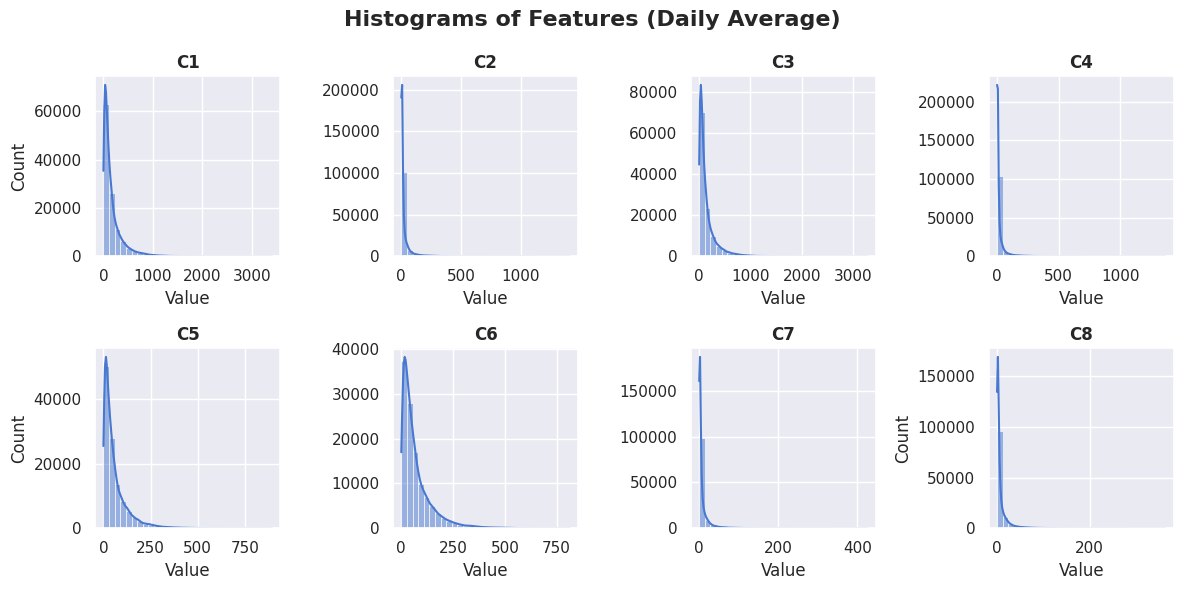

In [ ]:
plot_histograms(daily_mean)

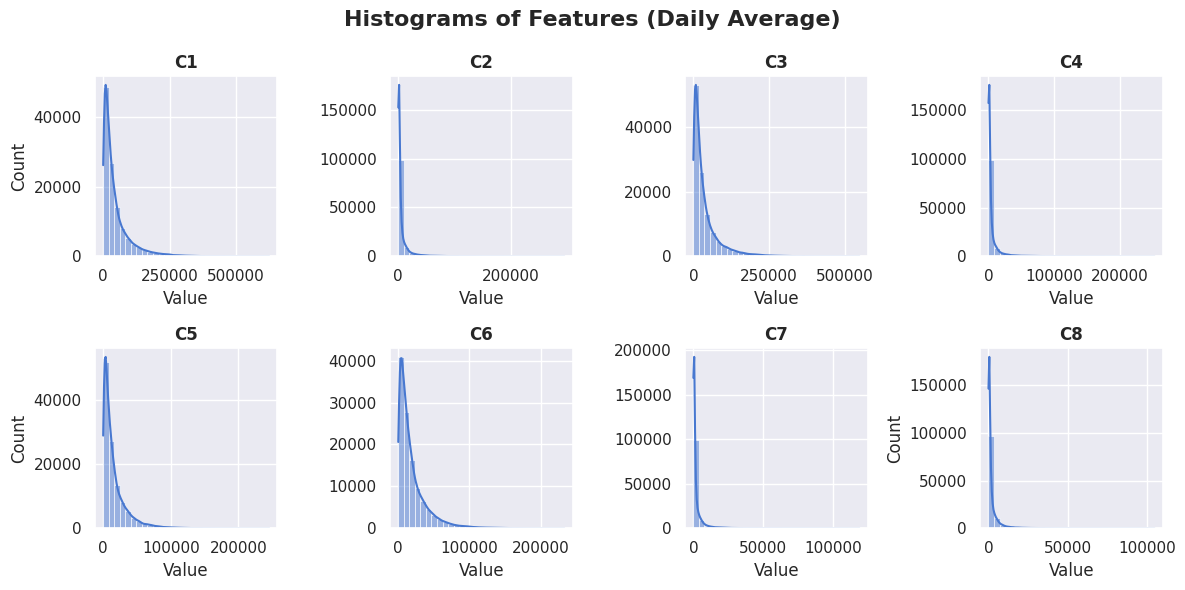

In [ ]:
plot_histograms(daily_sum)

Long tails for some of these features! We've also seen that the max value tends to be quite a bit larger than the 99th percetile, there is a possibility that we are dealing with anomalies (i.e. values that are errors). Since we are interested in outliers (values outside of the distribution, but that are real), if we're interested in removing possible anomalies, we have to do so with care, to avoid removing outliers.

Some methods to consider when removing anomalies:
- Interquartile Range (IQR) method: calculate range between quartile 1 and 3 (percentile 25 and 75 respectively), and use that as a "guiding measure". Probably risky in our case since we're dealing with seemingly long tailed distributions.
- Z-score method: calculate the number of standard deviations each data point is away from the mean, and cut-off data points where that value is above a certain threshold. Possible, but using the mean with long tails is probably not the best.
- Modified Z-score: use the median instead of the mean, more robust than the regular Z-score for long tailed distributions (less sensitive to extreme values).
- Isolation Forest: relatively insensitive to the underlying distribution of the data, but more complex to implement.

Given this, a good starting point would be using the modified Z-score method.

* Removing Anomalies

In [ ]:
def mad_based_outlier(points, threshold=3.5):
    """
    Identify outliers using the modified Z-score method based on the median absolute deviation (MAD).

    Args:
    points (numpy.array): An array containing the data points.
    threshold (float): The modified Z-score threshold to identify outliers, default is 3.5.

    Returns:
    numpy.array: A boolean array indicating whether each point is an outlier.
    """
    # Calculate the median
    median = np.median(points, axis=0)

    # Calculate the absolute deviation from the median for each data point
    abs_deviation = np.abs(points - median)

    # Calculate the median absolute deviation (MAD)
    mad = np.median(abs_deviation, axis=0)

    # Calculate the modified Z-score using the constant 0.6745
    modified_z_scores = 0.6745 * (abs_deviation / (mad + 1e-6))

    # Identify the outliers using the threshold
    return np.abs(modified_z_scores) > threshold

The value 0.6745 is used to scale the MAD estimator to make it consistent with the standard deviation of a normally distributed dataset. This scaling factor is derived as follows:
1. For a standard normal distribution (mean=0 and std_dev=1), the cumulative distribution function (CDF) at 0.75 is equal to the z-score of 0.6745.
2. In other words, if we have a normally distributed dataset, approximately 75% of the data points lie below the z-score of 0.6745.
3. So, when using the MAD-based modified Z-score, the constant 0.6745 is used to make the estimate consistent with the standard Z-score when the underlying distribution is normal.

What threshold should we use? To calculate that, let's plot the number of data points to consider anomalies versus the threshold.

In [ ]:
def count_outliers(dataframe, columns, threshold, grid_id_col='Grid_ID'):
    """
    Count the number of outliers in the dataframe using the modified Z-score method 
    (on a per grid_id basis).

    Args:
    dataframe (pd.DataFrame): The dataframe containing the data.
    columns (List[str]): The columns to count the outliers from.
    threshold (float): The modified Z-score threshold to identify outliers.

    Returns:
    int: The total number of outliers in the specified columns.
    """
    outlier_count = 0
    print(f"Threshold: {threshold}")
    for grid_id in tqdm(dataframe[grid_id_col].unique()):
        grid_data = dataframe[dataframe[grid_id_col] == grid_id]

        for column in columns:
            # Use the mad_based_outlier function to find outliers in the current column
            outliers_mask = mad_based_outlier(grid_data[column].values, threshold)
            outlier_count += np.sum(outliers_mask)

    return outlier_count

Threshold: 1.0


100%|██████████| 3743/3743 [01:33<00:00, 40.23it/s]


Threshold: 2.0


100%|██████████| 3743/3743 [01:34<00:00, 39.68it/s]


Threshold: 3.0


100%|██████████| 3743/3743 [01:31<00:00, 40.79it/s]


Threshold: 4.0


100%|██████████| 3743/3743 [01:14<00:00, 50.31it/s]


Threshold: 5.0


100%|██████████| 3743/3743 [01:15<00:00, 49.28it/s]


Threshold: 6.0


100%|██████████| 3743/3743 [01:16<00:00, 49.09it/s]


Threshold: 7.0


100%|██████████| 3743/3743 [01:15<00:00, 49.39it/s]


Threshold: 8.0


100%|██████████| 3743/3743 [01:15<00:00, 49.52it/s]


Threshold: 9.0


100%|██████████| 3743/3743 [01:16<00:00, 49.18it/s]


Threshold: 10.0


100%|██████████| 3743/3743 [01:16<00:00, 48.94it/s]


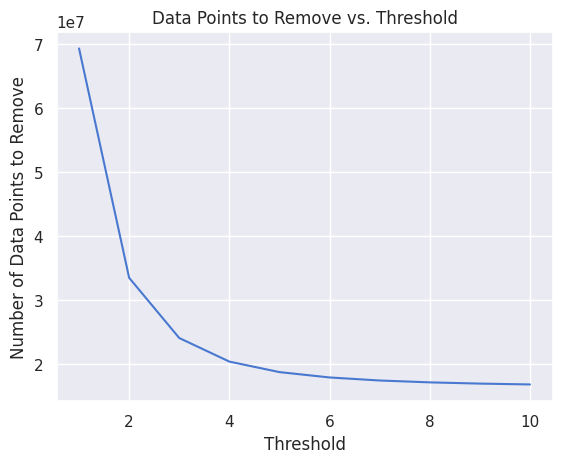

In [ ]:
# Relevant features
columns_to_check = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

# Create a list of thresholds to test
thresholds = np.linspace(1, 10, 10)

# Count the number of outliers for each threshold
outlier_counts = [count_outliers(df_movs, columns_to_check, threshold) for threshold in thresholds]

# Plot the number of data points removed versus the threshold
plt.plot(thresholds, outlier_counts)
plt.xlabel('Threshold')
plt.ylabel('Number of Data Points to Remove')
plt.title('Data Points to Remove vs. Threshold')
plt.show()

To avoid losing outliers, an aggressive approach can be used, by selecting a threshold where, even if the threshold would be bigger, the number of data points to remove would remain relatively the same. Considering that, selecting a threshold of 8 seems to be a good choice, i.e. a point is considered an anomaly if it's an outlier with a distance to the median 8 times higher than the median distance to the median (adjusted with the 0.6745 constant).

In [ ]:
# Count the number of outliers using the threshold of 8
outliers_count = count_outliers(df_movs, columns_to_check, threshold=8)

# Calculate the total number of data points in the selected columns
total_data_points = len(df_movs) * len(columns_to_check)

# Calculate the percentage of anomalies
percentage_anomalies = (outliers_count / total_data_points) * 100

print(f"Percentage of values considered anomalies: {percentage_anomalies:.2f}%")

Threshold: 8


100%|██████████| 3743/3743 [01:29<00:00, 41.93it/s]

Percentage of values considered anomalies: 6.96%


This percentage seems a bit high. Let's look at how many of these are isolated outliers, i.e. outliers where both the previous and the afterwards value are not outliers. Random spikes probably have a higher change of being outliers. Semi-isolated outliers are those where at least one of the adjacent data points are not outliers.

In [ ]:
def count_isolated_outliers(dataframe, columns, grid_id_col='Grid_ID', threshold=8):
    """
    Count the number of isolated and semi isolated outliers in the dataframe for each Grid_ID.

    Args:
    dataframe (pd.DataFrame): The dataframe containing the data.
    columns (List[str]): The columns to count the isolated outliers from.
    grid_id_col (str): The name of the column containing Grid_ID, default is 'Grid_ID'.
    threshold (float): The modified Z-score threshold to identify outliers, default is 8.

    Returns:
    int: The total number of isolated outliers in the specified columns.
    """
    isolated_outliers_count = 0
    semi_isolated_outliers_count = 0

    for grid_id in dataframe[grid_id_col].unique():
        for column in columns:
            grid_data = dataframe[dataframe[grid_id_col] == grid_id]
            
            # Use the mad_based_outlier function to find outliers in the current column
            outliers_mask = mad_based_outlier(grid_data[column].values, threshold)
            
            for i, is_outlier in enumerate(outliers_mask):
                # Check if the current point is an outlier and not the first or last index
                if is_outlier and 0 < i < len(outliers_mask) - 1:
                    # Check if both previous and next values are not outliers
                    if not (outliers_mask[i - 1] or outliers_mask[i + 1]):
                        isolated_outliers_count += 1
                    if not outliers_mask[i - 1] or not outliers_mask[i + 1]:
                        semi_isolated_outliers_count += 1

    return isolated_outliers_count, semi_isolated_outliers_count

In [ ]:
# Count the number of isolated outliers
isolated_outliers_count, semi_isolated_outliers_count = count_isolated_outliers(df_movs, columns_to_check, threshold=8)

# Calculate the percentage of isolated anomalies
percentage_isolated_anomalies = (isolated_outliers_count / total_data_points) * 100
percentage_semi_isolated_anomalies = (semi_isolated_outliers_count / total_data_points) * 100

print(f"Percentage of isolated values considered anomalies: {percentage_isolated_anomalies:.2f}%")
print(f"Percentage of semi-isolated values considered anomalies: {percentage_semi_isolated_anomalies:.2f}%")

Percentage of isolated values considered anomalies: 2.81%
Percentage of semi-isolated values considered anomalies: 5.66%


Considering that a significant percentage of the assumed anomalies ("level 8" outliers) are either isolated or semi-isolated, it seems reasonable to replace those values with interpolated values from the previous and next values.

In [ ]:
def replace_first_last_val(grid_data, z_scores, value, column):
    """
    Replace either the first or the last value of the grid ID data
    if needed, this is, if z_score is true.
    """
    if value == "first":
        z_sc_ind = 0
        range_start = 1
        direction = 1
    elif value == "last":
        z_sc_ind = -1
        range_start = 2
        direction = -1

    if z_scores[z_sc_ind]:
        for i in range(range_start, len(z_scores)):
            val_ind = direction * i
            if not z_scores[val_ind]:
                grid_data[column].iloc[z_sc_ind] = grid_data[column].iloc[val_ind]
                z_scores[z_sc_ind] = False
                break
    
    return grid_data, z_scores

In [ ]:
def replace_outliers_with_custom_interpolation(grid_data, columns, 
                                                  threshold=8):
    """
    Replace outliers in the specified columns of the grid_data dataframe with
    custom interpolation. The custom interpolation logic is as follows:
    1. If both the previous and next data points are not outliers, replace the
       current outlier with the average of the two surrounding data points.
    2. If only the previous data point is not an outlier, replace the current
       outlier with the previous data point value.
    3. If the first value is an outlier, replace it with the nearest non-outlier
       value.

    Parameters:
    grid_data (pd.DataFrame): Dataframe containing the grid data for a single
                              Grid_ID.
    columns (list): List of column names to apply the custom interpolation.
    threshold (float, optional): Threshold for determining outliers.
                                  Defaults to 8.

    Returns:
    None (reduces memory usage)
    """

    for column in columns:
        # Calculate modified Z-scores
        z_scores = mad_based_outlier(grid_data[column].values, threshold)

        # Check if the first and last value is an anomaly and 
        # replace it with the nearest non-anomaly value
        grid_data, z_scores = replace_first_last_val(grid_data, z_scores, "first",
                                                     column)
        grid_data, z_scores = replace_first_last_val(grid_data, z_scores, "last",
                                                     column)

        # Create masks for previous, current, and next data points
        # For each data point, we can easily check if it's isolated/semi isolated
        prev_z_scores = np.concatenate(([False], z_scores[:-1]))
        next_z_scores = np.concatenate((z_scores[1:], [False]))

        # Identify cases where both previous and next data points are not outliers
        # This is, Isolated outliers
        # Use .shift to quickly access the previous and next values
        both_not_outliers_mask = np.logical_not(
            np.logical_or(prev_z_scores, next_z_scores))
        
        relevant_idx = (z_scores == True) & both_not_outliers_mask

        grid_data.loc[relevant_idx, column] = ((
            grid_data.loc[:, column].shift(-1) +
            grid_data.loc[:, column].shift(1)) / 2)[relevant_idx]

        # Isolated anomalies have been fixed
        z_scores[(z_scores == True) & both_not_outliers_mask] = False

        # Identify cases where only the previous data point is not an outlier
        prev_not_outlier_mask = np.logical_not(prev_z_scores)

        relevant_idx = (z_scores == True) & prev_not_outlier_mask

        grid_data.loc[relevant_idx, column] = (
            grid_data.loc[:, column].shift(1))[relevant_idx]

        
    return grid_data

In [ ]:
def replace_outliers(df, grid_id_col='Grid_ID'):
    for grid_id in tqdm(df[grid_id_col].unique()):
        grid_data = df[df[grid_id_col] == grid_id]
        grid_data = grid_data.sort_values(by=['Datetime'])
        new_grid_data = replace_outliers_with_custom_interpolation(grid_data,
                                                                   columns_to_check)
        df[df[grid_id_col] == grid_id] = new_grid_data
    return df

In [ ]:
df_movs.head()

,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Hour,Day,Month,Weekday
0,1,2022-09-07 12:30:00+00:00,3.69,0.0,3.69,0.0,0.00,5.28,0.0,0.00,12,7,9,2
1,1,2022-09-07 22:30:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,22,7,9,2
2,1,2022-09-07 23:00:00+00:00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.00,23,7,9,2
3,1,2022-09-07 18:00:00+00:00,15.72,0.0,10.48,0.0,5.24,6.84,0.0,2.45,18,7,9,2
4,1,2022-09-07 06:30:00+00:00,3.86,0.0,1.93,0.0,3.86,4.43,0.0,0.00,6,7,9,2


In [ ]:
# Relevant features
columns_to_check = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

df_movs = replace_outliers(df_movs)

 11%|█         | 416/3743 [00:22<03:02, 18.18it/s]/tmp/ipykernel_5007/1699581130.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data[column].iloc[z_sc_ind] = grid_data[column].iloc[val_ind]
100%|██████████| 3743/3743 [03:05<00:00, 20.21it/s]


In [ ]:
df_movs['Day'] = df_movs['Datetime'].dt.day
daily_mean = df_movs.groupby(['Grid_ID', 'Day']).mean().reset_index()
daily_sum = df_movs.groupby(['Grid_ID', 'Day'])[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']].sum().reset_index()

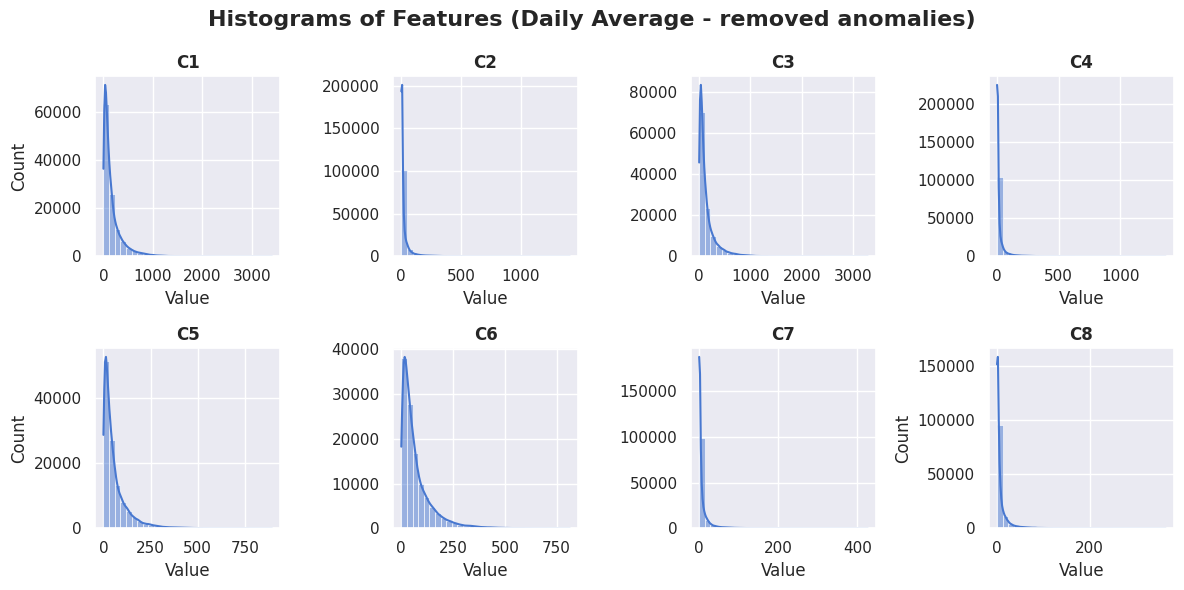

In [ ]:
plot_histograms(daily_mean, description="Daily Average - removed anomalies")

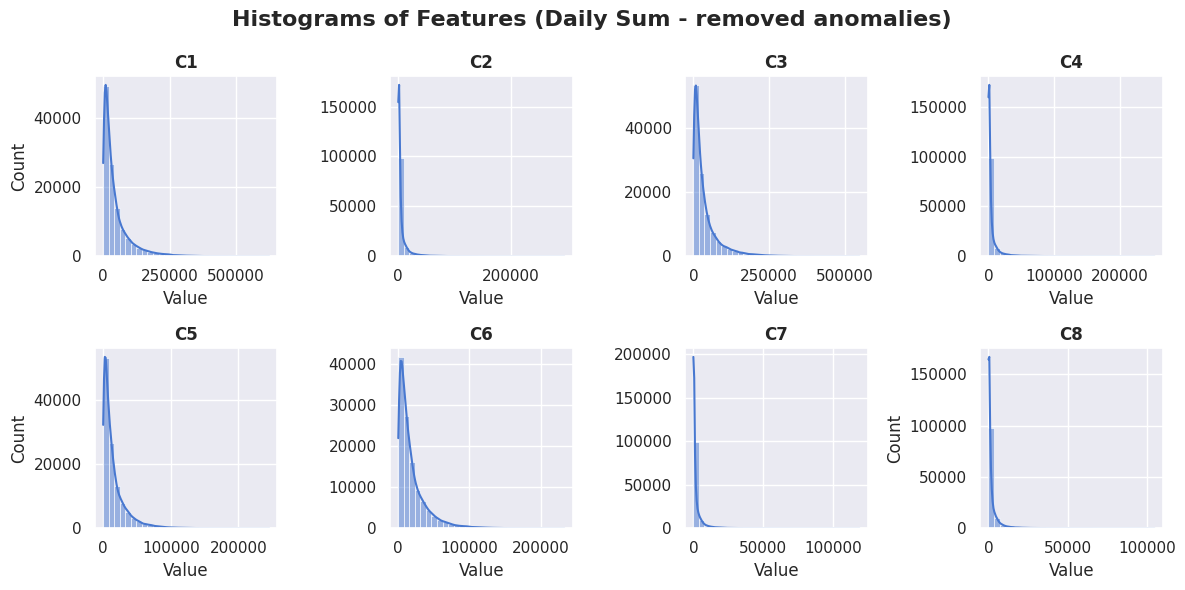

In [ ]:
plot_histograms(daily_sum, description="Daily Sum - removed anomalies")

Lookig at the histograms, they don't seem too different, but we can now be sure that the most extreme outliers, which are being considered anomalies, were removed.

* Ad Hoc Analysis

Which were the days with the highest values? Did anything happen to cause them?

In [ ]:
daily_max = df_movs.groupby(['Grid_ID', 'Day']).max().reset_index()
daily_min = df_movs.groupby(['Grid_ID', 'Day']).min().reset_index()

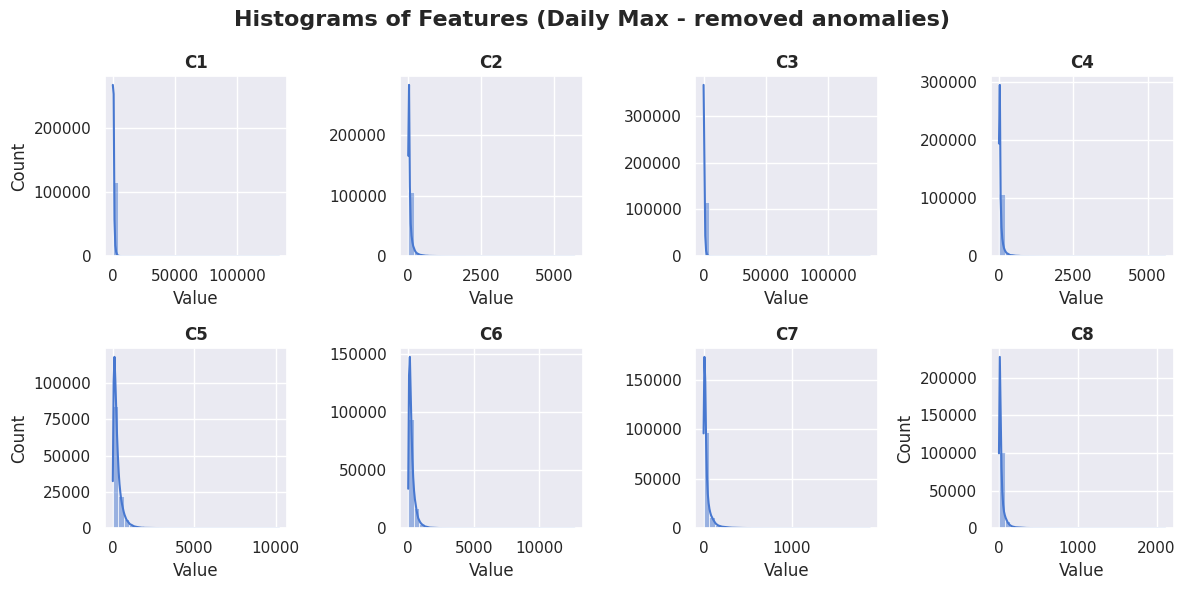

In [ ]:
plot_histograms(daily_max, description="Daily Max - removed anomalies")

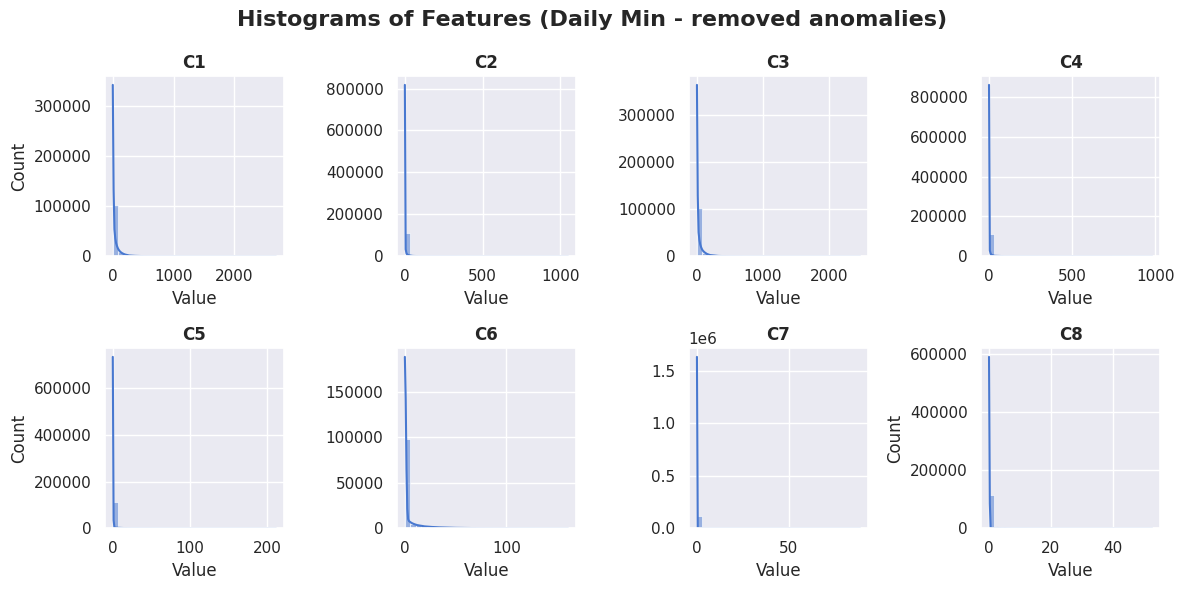

In [ ]:
plot_histograms(daily_min, description="Daily Min - removed anomalies")

It seems that the daily max and minimum distributions have veeeery long tails, meaning that for a very large majority of the days the max and the min values are the same, and then for the rest of the days there's no clear pattern.

In [ ]:
daily_max.head()

,Grid_ID,Day,Datetime,C1,C2,C3,C4,C5,C6,C7,C8
0,1,1,2022-11-01 23:45:00+00:00,14.710000,11.78,12.370000,11.78,2.21,4.050000,0.00,0.00
1,1,2,2022-11-02 23:45:00+00:00,12.900000,14.89,17.600000,8.86,14.99,24.910000,2.87,7.39
2,1,3,2022-11-03 23:45:00+00:00,21.600000,4.45,22.120001,4.45,8.37,9.780000,1.61,0.00
3,1,4,2022-11-04 23:45:00+00:00,14.630000,5.48,28.830000,5.48,9.13,8.100000,1.73,2.87
4,1,5,2022-11-05 23:45:00+00:00,20.870001,3.50,20.870001,3.50,10.03,17.719999,2.98,5.69


Let's calculate the average daily activity for the entire city, and check which days had the most activity. Then we can look at the days with the most activity and cross with relevant events such as big shows or big soccer matches to check if there is a correlation.

In [ ]:
daily_activity_entire_city = df_movs.groupby(['Day']).mean().reset_index()

In [ ]:
daily_activity_entire_city.head()

,Day,Grid_ID,Datetime,C1,C2,C3,C4,C5,C6,C7,C8
0,1,1872.000000,2022-10-01 19:52:30+00:00,139.634021,23.682883,122.170502,21.413652,38.990229,56.359596,5.472491,6.532791
1,2,1872.000000,2022-10-02 19:52:30+00:00,151.858675,23.478980,127.361215,20.032187,52.180949,65.397748,7.591489,7.970732
2,3,1872.000000,2022-10-03 19:52:30+00:00,159.678295,22.634840,133.662208,19.386018,54.846892,64.169083,7.207235,7.122033
3,4,1872.456707,2022-10-04 19:52:40.602497792+00:00,157.337565,22.368470,132.862774,19.259546,52.030217,60.620236,6.920688,6.850066
4,5,1871.862619,2022-10-05 19:56:18.513948416+00:00,148.386665,22.131065,124.183567,18.894507,50.679286,63.026680,7.012881,7.174617


In [ ]:
# Find the top 10 days for each feature
top_10_days = {}
features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
for feature in features:
    top_10 = daily_activity_entire_city[feature].nlargest(10)
    top_10_days[feature] = top_10

In [ ]:
daily_activity_entire_city["C1"].nlargest(10)

20    214.345491
25    199.452538
29    193.701126
26    192.687645
23    190.250865
27    187.042732
21    186.813640
18    185.252387
19    182.415244
22    181.503364
Name: C1, dtype: float64

In [ ]:
daily_activity_entire_city.iloc[20]

Day                                          21
Grid_ID                                  1872.0
Datetime    2022-10-16 12:02:11.067961344+00:00
C1                                   214.345491
C2                                    27.808239
C3                                   168.192587
C4                                    21.988107
C5                                    86.265148
C6                                    88.886084
C7                                    11.303473
C8                                    10.306562
Name: 20, dtype: object

In [ ]:
# Find the overlaps in the days between the features
overlapping_days = set(top_10_days[features[0]].index)
for feature in features[1:]:
    overlapping_days &= set(top_10_days[feature].index)

print("Overlapping days between features:", overlapping_days)

Overlapping days between features: {25, 20, 21, 23}


In [ ]:
daily_activity_entire_city.iloc[19]

Day                                          20
Grid_ID                                  1872.0
Datetime    2022-10-03 22:00:46.551724032+00:00
C1                                   182.415244
C2                                    26.218988
C3                                   158.347296
C4                                    22.910991
C5                                    54.673879
C6                                    66.507242
C7                                     7.876474
C8                                     8.036312
Name: 19, dtype: object

In [ ]:
for index in overlapping_days:
    print(daily_activity_entire_city["Datetime"].iloc[index])

2022-10-26 22:50:58.474576128+00:00
2022-10-16 12:02:11.067961344+00:00
2022-10-22 19:54:35.874125824+00:00
2022-10-24 19:52:30+00:00


In [ ]:
daily_activity_entire_city["Datetime"].iloc[]

* Temporal EDA

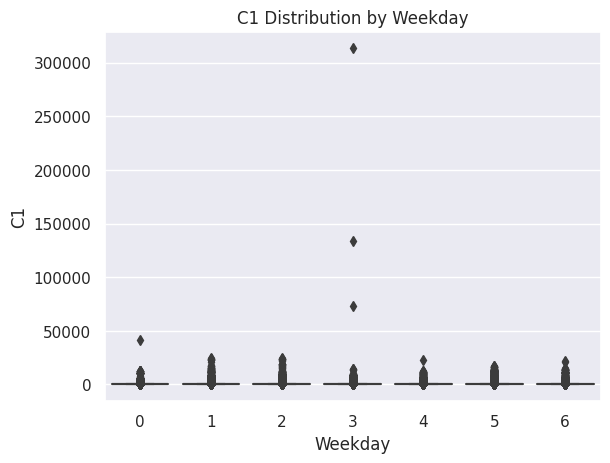

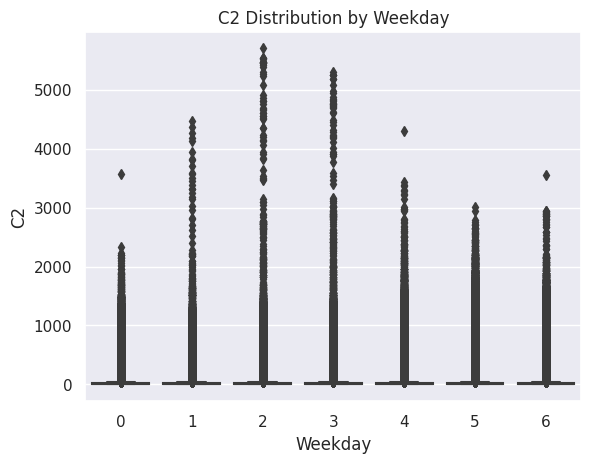

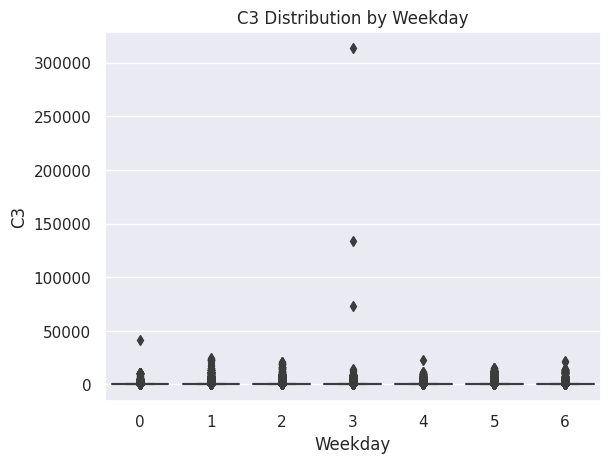

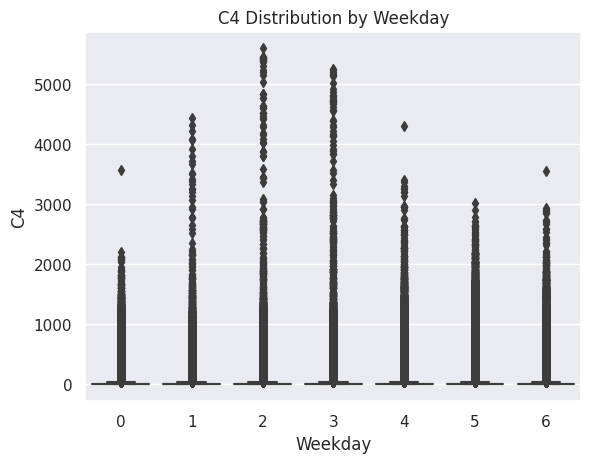

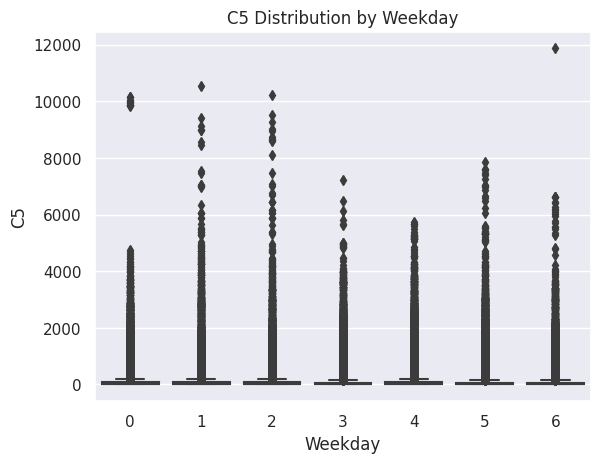

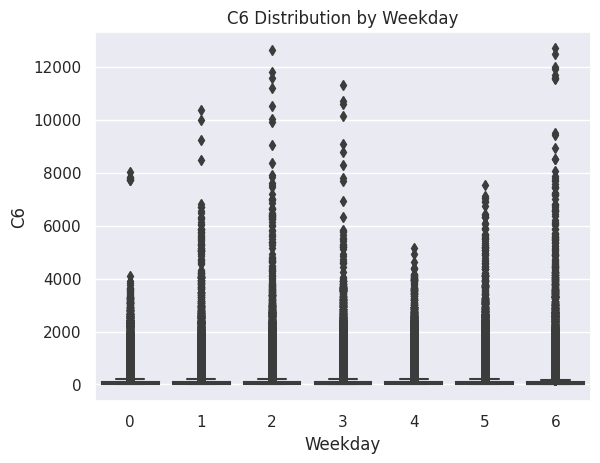

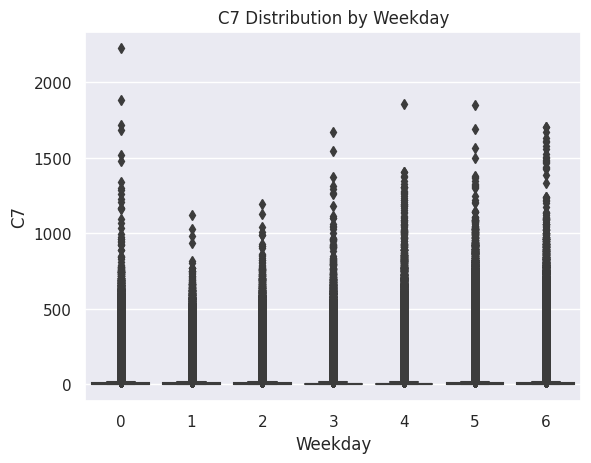

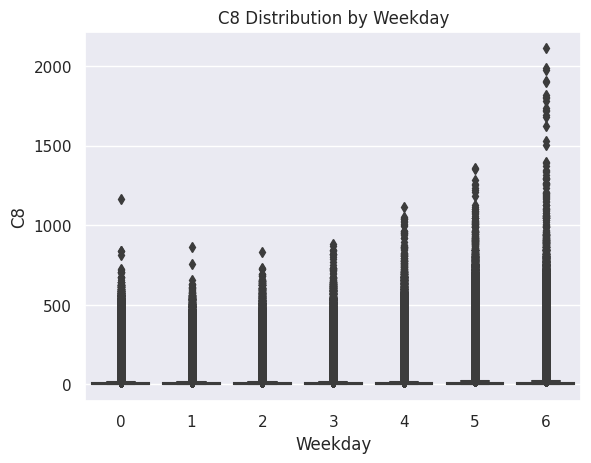

In [ ]:
# Create a box plot or violin plot for each feature (C1 to C8)
for col in ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']:
    plt.figure()
    sns.boxplot(x='Weekday', y=col, data=df_movs)
    # Optionally, use violin plot instead of box plot
    # sns.violinplot(x='Weekday', y=col, data=df)
    plt.title(f'{col} Distribution by Weekday')
    plt.show()

* Spatial EDA

In [ ]:
hourly_mean = df_movs.groupby(['Grid_ID', 'Hour']).mean().reset_index()

In [ ]:
hourly_mean.head()

,Grid_ID,Hour,Datetime,C1,C2,C3,C4,C5,C6,C7,C8,Day,Month,Weekday
0,1,0,2022-10-14 18:40:07.826086912+00:00,2.388290,0.252464,2.126638,0.238290,0.577159,0.703449,0.050203,0.029304,15.223188,9.973913,3.037681
1,1,1,2022-10-14 21:11:20.232558336+00:00,2.515116,0.224855,2.299273,0.196395,0.906686,0.491483,0.037500,0.029128,15.197674,9.976744,3.034884
2,1,2,2022-10-14 22:11:20.232558336+00:00,3.407296,0.163808,3.097733,0.154157,0.489360,0.405901,0.044797,0.008634,15.197674,9.976744,3.034884
3,1,3,2022-10-15 04:26:31.691394816+00:00,4.577597,0.247448,4.366944,0.241395,0.982908,0.339496,0.065875,0.021306,15.068249,9.988131,3.008902
4,1,4,2022-10-15 04:22:30+00:00,3.380060,0.262530,3.314315,0.248869,0.545506,0.355179,0.013661,0.015565,15.023810,9.988095,3.000000


In [ ]:
# Pivot the result to have hours as columns for c1
c1_hourly_mean_pivot = hourly_mean.pivot_table(values='C1', index='Grid_ID', columns='Hour').reset_index()

In [ ]:
c1_hourly_mean_pivot.head()

Hour,Grid_ID,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1,2.388290,2.515116,3.407296,4.577597,3.380060,3.141707,2.832411,3.852946,2.574107,...,5.427384,5.291347,5.899186,5.584323,4.741149,3.584684,3.400684,3.808977,2.785739,2.897213
1,2,3.599652,3.002180,2.109070,1.784451,2.665476,2.491138,3.898690,5.021131,5.063393,...,8.998517,8.947736,12.492267,8.833112,5.567902,5.030115,4.611880,3.405057,4.759432,4.775603
2,3,3.013768,2.471919,2.112442,2.459139,3.126667,3.644311,5.829048,7.880595,9.194821,...,15.788546,13.695444,20.755785,17.321614,10.579569,9.909540,7.013989,6.147955,6.315057,4.810144
3,4,3.778754,3.497907,3.481744,3.747389,3.360208,3.031317,3.488542,5.453631,8.042202,...,19.672326,16.608052,15.678721,13.889251,10.985172,9.726494,7.370541,8.819432,4.752983,3.967931
4,5,15.694638,16.703517,15.888605,13.346577,14.437054,15.207754,16.931994,17.432500,16.878988,...,37.608023,34.410630,32.866337,31.271902,25.144828,20.498649,17.323248,15.146733,14.183153,14.680115


In [ ]:
# Merge the grid geometry and hourly average values;
# This will create a dataframe that has (besides other things) the grid id,
# the grid_id geometry, and the values for C1 from hour 0 to hour 23 (average of the 3 months)
grid_gdf = grid_gdf.merge(c1_hourly_mean_pivot, on='Grid_ID')

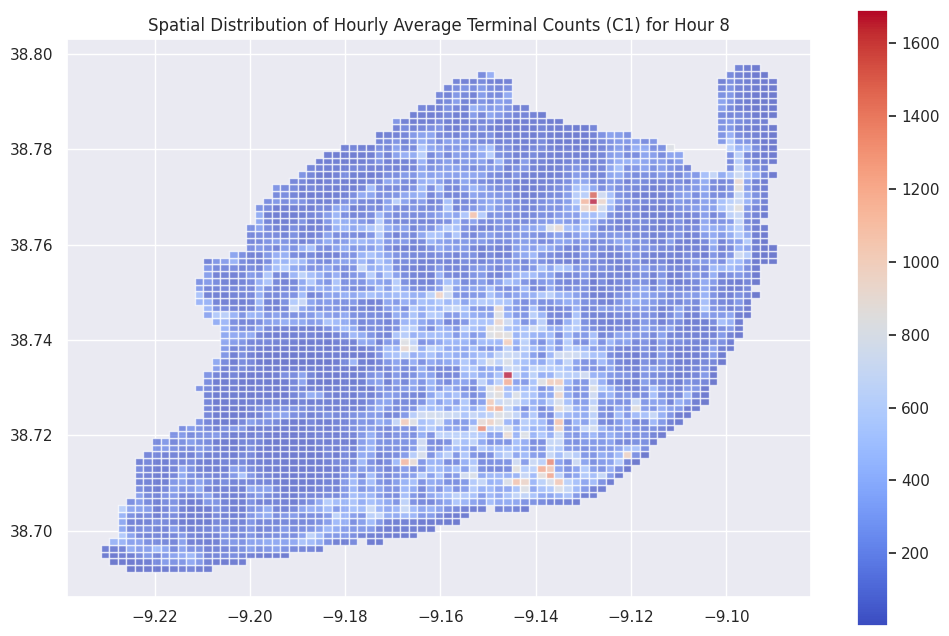

In [ ]:
# Plot the C1 values for a specific hour (e.g., hour 12)
hour_to_plot = 8
fig, ax = plt.subplots(figsize=(12, 8))
grid_gdf.plot(column=hour_to_plot, cmap='coolwarm', legend=True, alpha=0.7, ax=ax)
plt.title(f'Spatial Distribution of Hourly Average Terminal Counts (C1) for Hour {hour_to_plot}')
plt.show()

In [ ]:
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

/tmp/ipykernel_8321/2226878670.py:20: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cbar.draw_all()


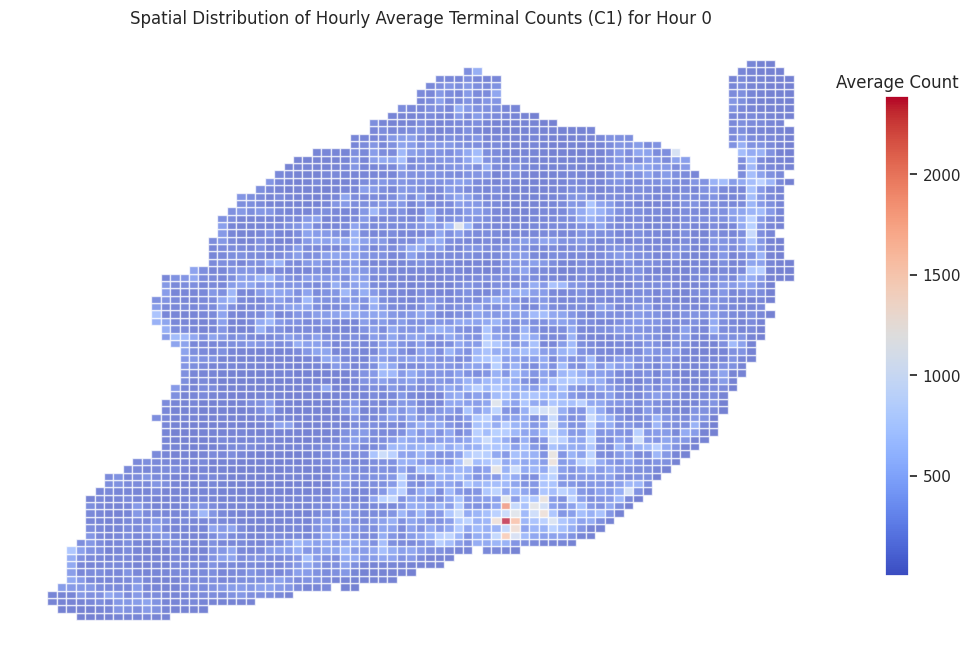

In [ ]:
# Create the animation with a single axis for the map
def create_animation():
    fig, ax_map = plt.subplots(figsize=(12, 8))
    cax = fig.add_axes([0.90, 0.2, 0.02, 0.6])  # Adjust the parameters to fit the colorbar inside the GIF
    colorbar_added = False

    def init():
        return update_heatmap(0),

    def update_heatmap(hour):
        nonlocal colorbar_added

        ax_map.clear()

        plot = grid_gdf.plot(column=hour, cmap='coolwarm', alpha=0.7, ax=ax_map)

        if not colorbar_added:
            cbar = fig.colorbar(plot.get_children()[0], cax=cax)
            cbar.set_alpha(1)
            cbar.draw_all()
            cax.set_title("Average Count")
            colorbar_added = True

        ax_map.set_title(f'Spatial Distribution of Hourly Average Terminal Counts (C1) for Hour {hour}')
        ax_map.set_axis_off()

        return ax_map,

    ani = animation.FuncAnimation(fig, update_heatmap, frames=range(0, 24), init_func=init, interval=1000, blit=False)
    return ani

# Create the animation
ani = create_animation()

# Save the animation as a GIF
ani.save('hourly_heatmap_animation.gif', writer=PillowWriter(fps=1))

What are the areas with higher activity?
Any reason why they have the highest activity?
What are the main roads/monuments/stadiums/points of interest, and how are they in the map?

### ⚙️ Modelling - Preliminary Preprocessing
As we were developing the modells in parallel with the EDA and did not have time to integrate both, here is the preliminary preprocessing pipeline we implemented.


In [ ]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt

Run these to get the gridded data

In [ ]:
# Data file names

grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")

#There are mov files for different datas, I'll add all of them here latter 
movs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_GRELHA E EIXOS")
movs_2022_09 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv")
movs_2022_10 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_10_0001_4000.csv")
movs_2022_11 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv")


In [ ]:
df_movs_2022_09= pd.read_csv(movs_2022_09)
df_movs_2022_10= pd.read_csv(movs_2022_10)
df_movs_2022_11= pd.read_csv(movs_2022_11)

In [ ]:
# Join the 3 months' dataframes:

df_movs = pd.concat([df_movs_2022_09, df_movs_2022_10, df_movs_2022_11])
del(df_movs_2022_09, df_movs_2022_10, df_movs_2022_11)

In [ ]:
# Create the 2d grid
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['latitude', 'longitude', 'grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

# coordinates
lats = dfs_grid_filtered['latitude'].values
lons = dfs_grid_filtered['longitude'].values
# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
grelha_id_2d[:] = np.nan
lat_2d = grelha_id_2d.copy()
lon_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])

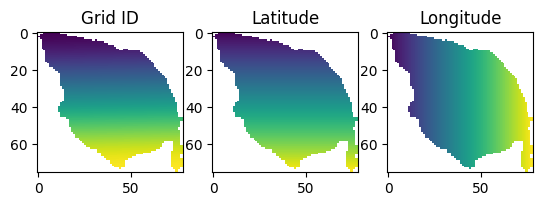

In [ ]:
# Assign the elements to the regular rectangular grid

grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
lat_2d[tuple(idx_2d)] = lats.ravel()
lon_2d[tuple(idx_2d)] = lons.ravel()

fig, axs = plt.subplots(1,3)

axs[0].set_title('Grid ID')
axs[0].imshow(grelha_id_2d)

axs[1].set_title('Latitude')
axs[1].imshow(lat_2d, vmax = lats.max(), vmin = lats.min())

axs[2].set_title('Longitude')
axs[2].imshow(lon_2d, vmax = lons.max(), vmin = lons.min())

In [ ]:
dfs_movs = [y for x, y in df_movs.groupby('Grid_ID', as_index=False)]

df_movs['Datetime'] = pd.to_datetime(df_movs['Datetime'])
dfs_movs_ordered = [dfs_movs[i].set_index('Datetime').sort_index() for i in range(len(dfs_movs))]
del(df_movs)
del(dfs_movs)

In [ ]:
# This was to check if each cell id had the same missing timeStamps, since it would allow for a simpler implementation

missing_time_stamps_old = pd.date_range(dfs_movs_ordered[0].index.min(), dfs_movs_ordered[0].index.max(), freq='15min').difference(dfs_movs_ordered[0].index)
for id in range(len(dfs_movs_ordered)):
    missing_time_stamps = pd.date_range(dfs_movs_ordered[id].index.min(), dfs_movs_ordered[id].index.max(), freq='15min').difference(dfs_movs_ordered[id].index)
    same_missing_values = len(missing_time_stamps_old.difference(missing_time_stamps)) == 0 and len(missing_time_stamps_old) == len(missing_time_stamps)
    if not same_missing_values:
        break
    missing_time_stamps_old = missing_time_stamps

In [ ]:

# Function to check if a given dataset has no missing timeStamps

# To use the function, one of the coordinates should be the timeStamp, grid_id and dateTime should not be mixed
# The expected input is a list of dataframes

def fill_dataset(dataset_list, fill_method='nan'):
    """

    Args:
    dataset_list (list):
    fill_method (str): either 'nan' or 'interpolated'
    """

    df_complete = list()

    for dataframe in dfs_movs_ordered:
        missing_time_stamps = pd.date_range(dataframe.index.min(), dataframe.index.max(), freq='15min').difference(dataframe.index)
        missing_values = dataframe.iloc[0:len(missing_time_stamps),:].copy()
        if fill_method in ['nan', 'interpolated']:
            missing_values.loc[:,:] = np.NaN
        else: 
            raise('Invalid Option')
        if fill_method == 'interpolated':
            complete_data = pd.concat([dataframe, missing_values]).sort_index().interpolate(method='linear')
            assert (complete_data == np.NaN).sum().sum() == 0, 'There are still NaN values...'
            df_complete.append(complete_data)
        else:
            df_complete.append(pd.concat([dataframe, missing_values]).sort_index())
    return df_complete

In [ ]:
fill_method = 'interpolated'
df_complete = fill_dataset(dfs_movs_ordered, fill_method='interpolated')
del(dfs_movs_ordered)

In [ ]:
from scipy import stats

# This is to have an undertanding of how many standard deviations should be used
grid_id = 1081
n_stdevs = 10
data = df_complete[grid_id]
statistics = stats.describe(data.iloc[:,1:])
stdev = statistics.variance**0.5
mean = statistics.mean

print(f' Maximum deviation allowed {n_stdevs} standard-deviations: \n{(mean + n_stdevs*stdev)}\n')
print(f' Number of values to remove from each collumn: \n{(data.iloc[:,1:] > (mean + n_stdevs*stdev) ).sum()}')

 Maximum deviation allowed 10 standard-deviations: 
[4847.92841552 1021.89121758 4388.24813074  938.80229782 2087.56393469
 2065.00291621  462.07981746  341.43793538]

 Number of values to remove from each collumn: 
C1    1
C2    0
C3    1
C4    0
C5    3
C6    0
C7    0
C8    0
dtype: int64


Removing non-realistic values

In [ ]:
for element in range(len(df_complete)):
    statistics = stats.describe(df_complete[element])
    stdev = statistics.variance**0.5
    mean = statistics.mean
    values_to_remove = (df_complete[element] > (mean + 10*stdev))
    df_complete[element][values_to_remove] = np.NaN
    df_complete[element] = df_complete[element].sort_index().interpolate(method='linear').ffill().bfill()
    assert np.isnan(df_complete[element]).sum().sum() == 0, f'There are NaN values in element:{element}'

In [ ]:
assert np.isnan(df_complete).sum() == 0, 'There are still NaN values...'

In [ ]:
nTimeStamps = len(df_complete[0].index)
grelha_id_3d = np.repeat(grelha_id_2d[..., np.newaxis], nTimeStamps, axis=-1)
lat_3d = np.repeat(lat_2d[..., np.newaxis], nTimeStamps, axis=-1)
lon_3d = np.repeat(lon_2d[..., np.newaxis], nTimeStamps, axis=-1)

In [ ]:
# Construct the dataset with the right dimensions

nTimeStamps = len(df_complete[0].index)
grelha_id_3d = np.repeat(grelha_id_2d[..., np.newaxis], nTimeStamps, axis=-1)

lat_3d = np.repeat(lat_2d[..., np.newaxis], nTimeStamps, axis=-1)
lon_3d = np.repeat(lon_2d[..., np.newaxis], nTimeStamps, axis=-1)

placeholder = np.full_like(grelha_id_3d, np.NAN)
C1_grid = placeholder
C2_grid = placeholder
C3_grid = placeholder
C4_grid = placeholder
C5_grid = placeholder
C6_grid = placeholder
C7_grid = placeholder
C8_grid = placeholder

In [ ]:
for id in np.unique(grelha_id):
    mask = grelha_id_3d[...,0] == id
    C1_grid[mask] = df_complete[id-1]['C1']
    C2_grid[mask] = df_complete[id-1]['C2']
    C3_grid[mask] = df_complete[id-1]['C3']
    C4_grid[mask] = df_complete[id-1]['C4']
    C5_grid[mask] = df_complete[id-1]['C5']
    C6_grid[mask] = df_complete[id-1]['C6']
    C7_grid[mask] = df_complete[id-1]['C7']
    C8_grid[mask] = df_complete[id-1]['C8']

#del(df_complete)

# Full array of data:
data = np.stack([grelha_id_3d, lat_3d, lon_3d, C1_grid, C2_grid, C3_grid, C4_grid, C5_grid, C6_grid, C7_grid, C8_grid], axis = -1)

(76, 79, 8736, 11)

In [ ]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

In [ ]:
# Save data the data array:
# Currently takes 4.6GB
with open(grid_path, 'wb') as f:
    np.save(f, data)

Run this to load the gridded data if already available

In [ ]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

### ⚙️ Modelling - CNN-LSTM

The proposed CNN-LSTM architecture joins state-of-the-art deep learning models for image processing (CNN, Convolutional Neural Network) and time series forecasting (LSTM, Long Short-Term Memory).

In theory, this model is able to leverage the spatial relationships within the city grid to provide better predictions based on neighbor relations, as well as the temporal dimension for forecasting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, RepeatVector
import pandas as pd
import csv
from datetime import datetime

In [ ]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

* Plot a picture of all values

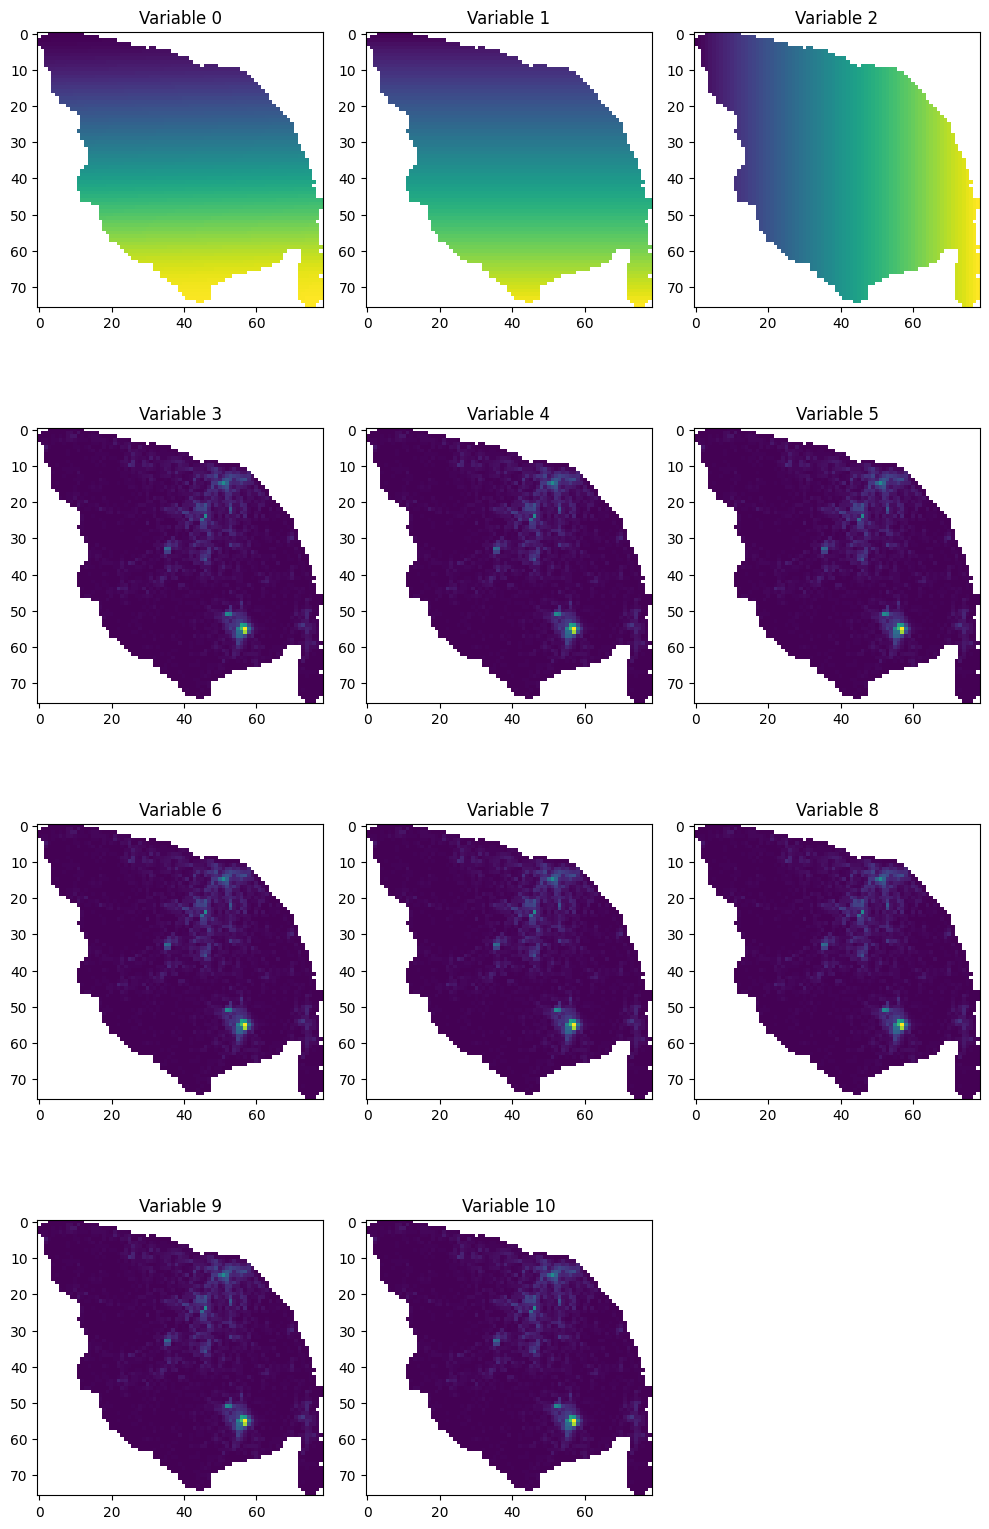

In [ ]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

Model definition and train

In [ ]:
# The depth of this model can be easily increased
# One could add more Conv layer
# Or increase the units on the LSTM to increase the model capability to fit the training data

# For now the model has only 136,167 parameters

def CNN_LSTM(input_shape, output_shape, forecast_range):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100))
    model.add(RepeatVector(forecast_range))
    model.add(LSTM(units=100, return_sequences= True))
    model.add(TimeDistributed(Dense(output_shape)))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

In [ ]:
N_IN_24_H = 24*4
FORECAST_RANGE = 4 # 1 hour

In [ ]:
def windowed_dataset(data, relevant_cells_mask, window_size, batch_size, shift, forecast_range):
    """
    """

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (window[:-forecast_range], tf.stack([window[-i,:,:,0][relevant_cells_mask] for i in range(forecast_range)])))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [ ]:
def ingestion(data, window_size, shift, batch_size, forecast_range):
    cell_ids = data[...,0,0]
    relevant_cells_mask = ~np.isnan(cell_ids)
    output_shape = relevant_cells_mask.sum()

    # Setting the timestep dim as the first dimensions
    data = np.transpose(data, (2, 0, 1, 3))
    print(f'Whole dataset shape: {data.shape}')

    # Using only the C's data
    x_data = data[...,3:]
    x_data[np.isnan(x_data)] = 0
    # Train/val split
    # Val and test data are split from training data, and correspond to the last month, ~2 weeks each. Cross-validation can be a valuable alternative for a future iteration.
    x_data_train = x_data[:int(x_data.shape[0]*2/3),...] 
    x_data_val = x_data[int(x_data.shape[0]*2/3):int(x_data.shape[0]*(2/3 + 1/6)),...]
    x_data_test = x_data[int(x_data.shape[0]*(2/3 + 1/6)):,...]

    train_dataset = windowed_dataset(x_data_train, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    validation_dataset = windowed_dataset(x_data_val, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    test_dataset = windowed_dataset(x_data_test, relevant_cells_mask, window_size, batch_size, shift, forecast_range)

    return train_dataset, validation_dataset, test_dataset, output_shape

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that. - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

def train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis):

    model = CNN_LSTM(input_shape, output_shape, forecast_range)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)
    # the patience parameter is the number of epochs with no improvement after which training will be stopped.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_scheduler])

    # summarize history for loss
    if vis:
        # list all data in history
        print(history.history.keys())

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    return model, history.history['loss'], history.history['val_loss']

* Run experiment

In [ ]:
def experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=5e-3, epochs=100, vis=False, model_path='model.h5', forecast_range=4):
    # Ingestion
    train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift, batch_size, forecast_range)
    input_shape = (None,96,76,79,8)

    # Train
    model, train_loss, val_loss = train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis)
    model.save(model_path)

    ## We don't need this anymore, the fit method will take care of that for us
    # # Model prediction
    # relevant_cells_mask = ~np.isnan(data[...,0,0])
    # ground_truth = x_data_val_and_test[N_IN_24_H,...,0][relevant_cells_mask]
    # pred, mse = predict_evaluate(model, x_data_val_and_test, ground_truth)

    return model, train_loss, val_loss, test_dataset

To run single experiment:
`model, train_loss, val_loss = experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=1e-2, vis=True, model_path='model.h5')`

* Iterate over multiple window_sizes

In [ ]:
header = ['timestamp', 'window', 'forecast_range', 'train_loss', 'val_loss']

In [ ]:
# fast

# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results_fast.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['24h_1h', '24h_12h', '48h_1h', '48h_12h', '48_24h', '96h_1h', '96h_12h', '96h_24h']
    # You may be able to increase these if your machine has more that 20 GiB of RAM
    batch_size_list = [32, 32, 16, 16, 16, 8, 8, 8, 8]
    FORECAST_RANGE_list = [4, 12*4, 4, 12*4, 24*4, 4, 12*4, 24*4]

    # The shift parameter is currently set to 1 (shift of 15 min) to use all the available data
    # The number of epochs is 200 but can be increased, but the callback may stop it sooner
    # The lr of 5e-3 might be hight but I think that lr = 1e-3 could make it slow

    writer.writerow(header)
    for i, window in enumerate([N_IN_24_H, N_IN_24_H, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*4, N_IN_24_H*4, N_IN_24_H*4]):
        _, train_loss, val_loss, _ = experiment(data, window_size = window+FORECAST_RANGE_list[i], shift = 25, batch_size=batch_size_list[i], lr=3e-3, epochs=60, vis=True, model_path = f'models/model{model_fn_list[i]}.h5', forecast_range= FORECAST_RANGE_list[i])
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, FORECAST_RANGE_list[i], train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

From this, we can evaluate different possibilities for training the model, regarding

* Using a trained model to perform predictions

Here we can either train a new model, or simply import one already trained.

In [ ]:
# Training a new model
window_size = N_IN_24_H + FORECAST_RANGE
FORECAST_RANGE = 4
shift = 24

model, train_loss, val_loss, test_dataset = experiment(data, window_size = window_size, shift = shift, batch_size=32, lr=5e-3, epochs=3, vis=True, model_path = f'models/model.h5', forecast_range= FORECAST_RANGE)
train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=shift, batch_size=1, forecast_range=FORECAST_RANGE)

In [ ]:
# Loading a previously trained model
# Here it is important to ensure that the test_dataset is using the same window_size and forecast_range as you used to train your model

window_size = N_IN_24_H + FORECAST_RANGE
FORECAST_RANGE = 4
shift = 4

train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=shift, batch_size=32, forecast_range=FORECAST_RANGE)
model = tf.keras.models.load_model('models/model.h5')

Next we predict on the whole test dataset. We evaluate the MSE there and save all the predictions

In [ ]:
def predict_evaluate(model, x_test, y_test):
    pred = model(x_test).numpy()
    mse = np.mean((y_test - pred)**2)
    return pred, mse

mse_list = []
pred_list = []
y_true_list = []

for x,y in test_dataset:
    pred, mse = predict_evaluate(model, x, y)
    mse_list.append(mse)
    pred_list.append(pred)
    y_true_list.append(y.numpy())
    
predictions = np.stack(pred_list[:-1])
ys = np.stack(y_true_list[:-1])

# Do not use the last mse value, it may be from a batch different than the batch size
# This happens if the total number of samples is not divisible by the batch size
MSE = np.mean(mse_list[:-1])
print(f'MSE for the test data: {MSE}')

Next we plot some predictions and compare it to our ground truth.

In [ ]:
# Function to convert the 1D prediction into a 2D image
def pred_into_grid(pred, ground_truth):

    grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
    dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

    # grid indexes
    grelha_x = dfs_grid['grelha_x'].values -1
    grelha_y = dfs_grid['grelha_y'].values -1
    grelha_id =  dfs_grid['grelha_id'].values 

    grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
    grelha_id_2d[:] = np.nan
    pred_2d = grelha_id_2d.copy()
    ground_truth_2d = grelha_id_2d.copy()

    # Indices to map from
    idx_2d = np.stack([grelha_y, grelha_x])

    # Assign the elements to the regular rectangular grid
    pred_2d[tuple(idx_2d)] = pred.ravel()
    ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()

    return pred_2d, ground_truth_2d

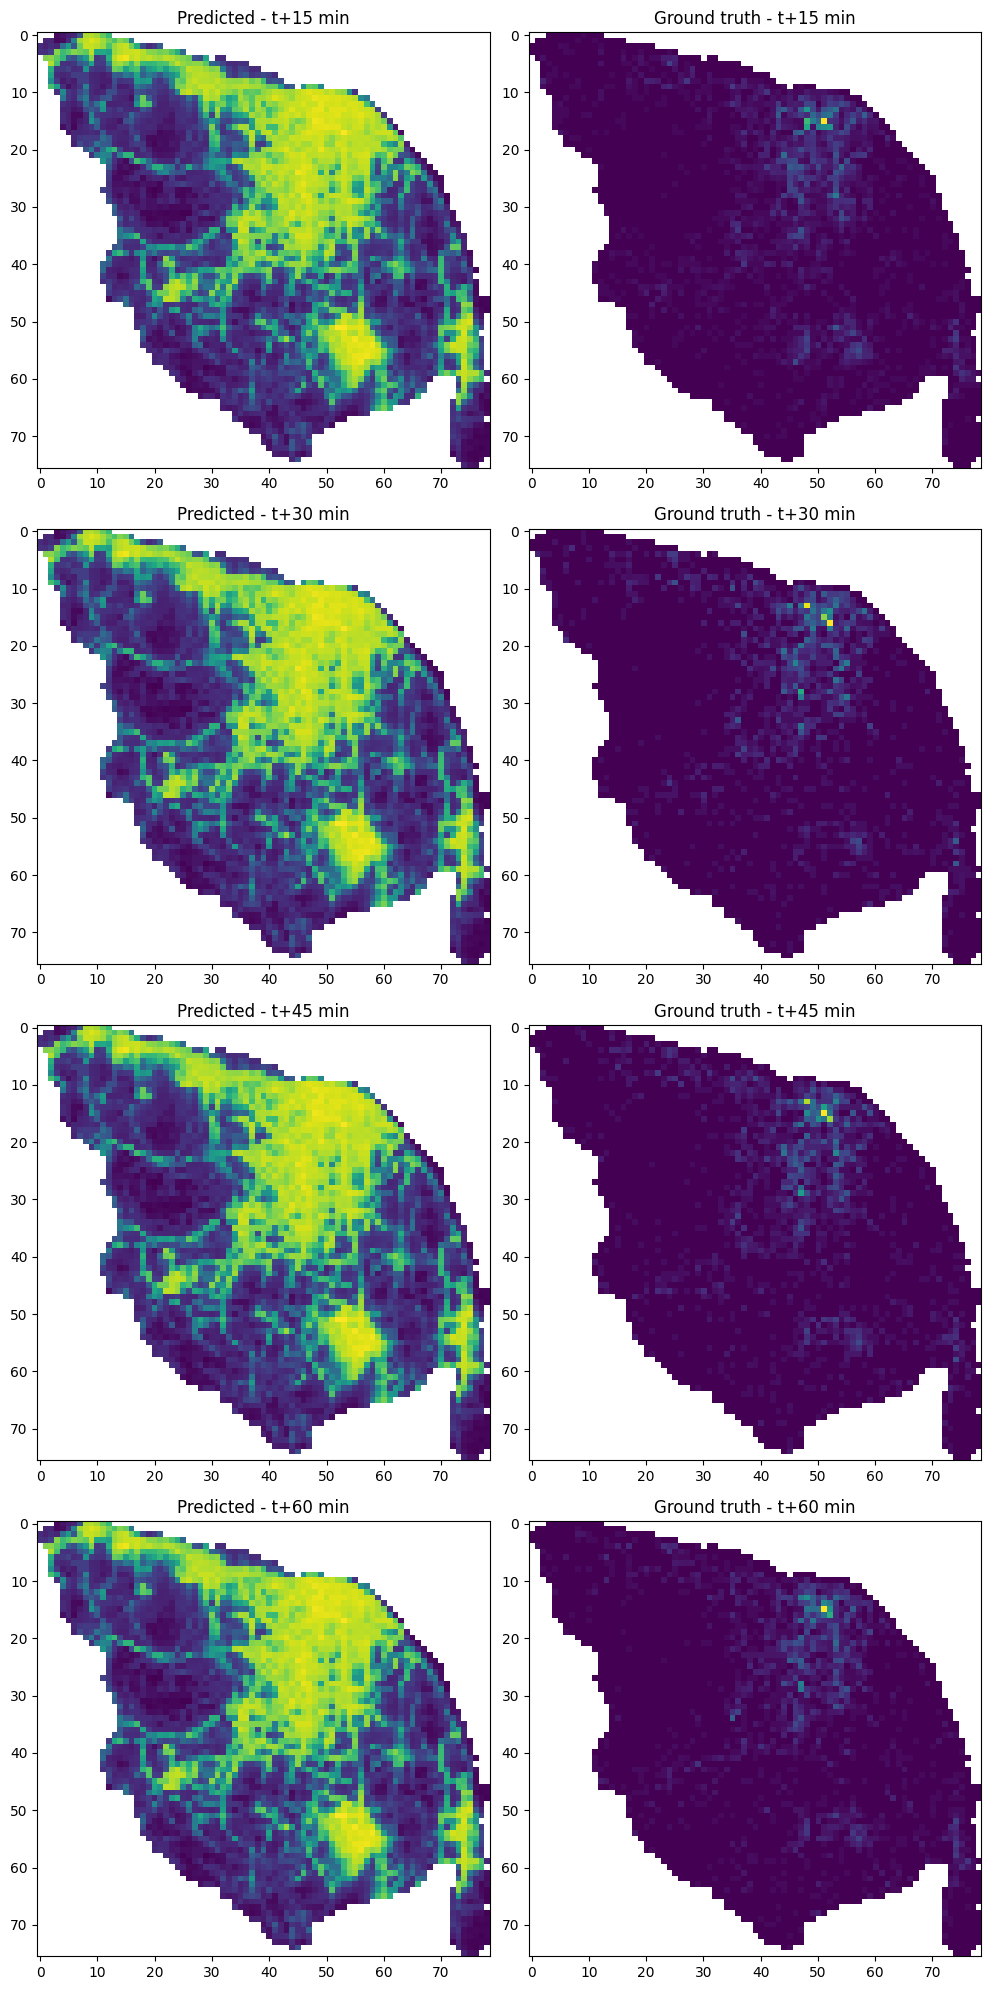

In [ ]:
example_pred  = predictions[0,0]
example_truth = ys[0,0]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for time in range(4):
    # Define some pred and ground truth here 
    pred_2d, ground_truth_2d = pred_into_grid(example_pred[time], example_truth[time])

    axs[time,0].set_title(f'Predicted - t+{15*(time+1)} min')
    axs[time,0].imshow(pred_2d)

    axs[time,1].set_title(f'Ground truth - t+{15*(time+1)} min')
    axs[time,1].imshow(ground_truth_2d)
plt.tight_layout()
plt.show()

Although still not too accurate as the learning time was limited, this shows the potential for future improvement.

In [ ]:
truth_stats = stats.describe(predictions.flatten())
pred_stats = stats.describe(ys.flatten())

print("RESULTS")
print("MSE:", MSE)
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)

RESULTS
MSE: 807.0118738145511
Ground Truth Stats: DescribeResult(nobs=4791040, minmax=(-0.14972183, 11.438719), mean=4.115102, variance=12.388175689029088, skewness=0.5816687875475826, kurtosis=-1.2019993077544802)
Predictions Stats:  DescribeResult(nobs=4791040, minmax=(0.0, 1107.0799560546875), mean=10.704583719830191, variance=841.7510284597387, skewness=9.053568265229877, kurtosis=140.18455767858933)


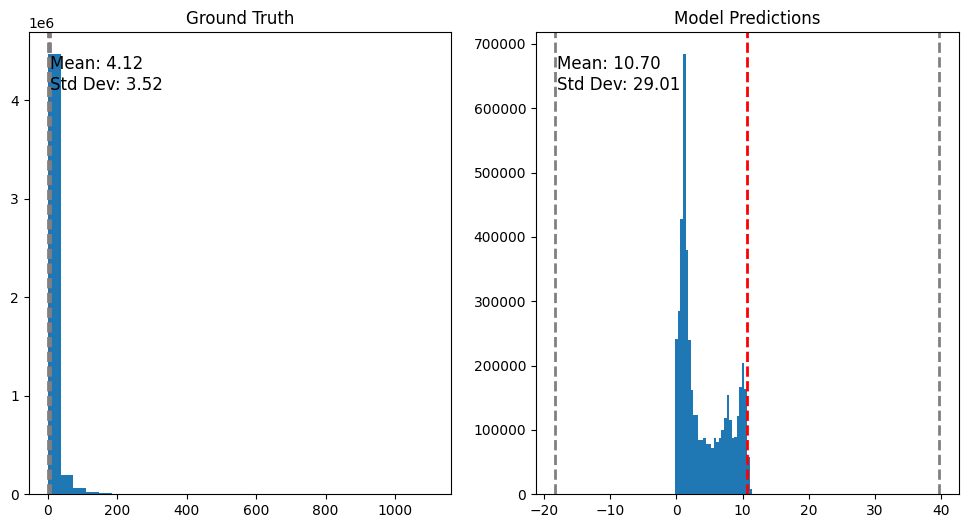

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ys.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(predictions.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()

Note that ground truths have high value outliers, which were cleaned prior to modelling

### **TODO** 🚇 Train Station Dataset - Exploratory Analysis & Proof-of-Concept
In addition to the phone grid data, we intend to add train station/route data and climate data, such as temperature and precipitation, in future implementations. 

We developed a proof-of-concept for the train station dataset, which involves transforming the data to concatenate with the phone grid and have the same resolution as the grid (200 x 200 meter units).

In [ ]:
import os
import folium
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from shapely import wkt


In [ ]:
# Read data from the xlsx file
grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
data = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

In [ ]:
data.head()

,grelha_id,dicofre,entity_id,entity_type,freguesia,freguesias,grelha_x,grelha_y,latitude,longitude,nome,objectid,position,wkt
0,1,110658,coi.tematica.grelha.lx.atributos.3518,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,4,1,38.692094,-9.225027,Área ribeirinha Pedrouços,1,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.22412591616028 38.691391736...
1,2,110658,coi.tematica.grelha.lx.atributos.3519,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,5,1,38.692094,-9.223231,Área ribeirinha Pedrouços,2,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.22232928559204 38.691391736...
2,3,110658,coi.tematica.grelha.lx.atributos.3520,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,6,1,38.692094,-9.221434,Área ribeirinha Pedrouços,3,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.2205326550238 38.6913917367...
3,4,110658,coi.tematica.grelha.lx.atributos.3521,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,7,1,38.692094,-9.219637,Torre de Belém,4,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.21873602445556 38.691391736...
4,5,110658,coi.tematica.grelha.lx.atributos.3522,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,8,1,38.692094,-9.217841,Torre de Belém,5,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.21693939388732 38.691391736...


In [ ]:
# Extract ids
ids = data["grelha_id"].tolist()

In [ ]:
# Function to remove extra curly braces and return a valid WKT string
def fix_wkt_string(wkt_string):
    return wkt_string.replace("{{{", "(((").replace("}}}", ")))")

In [ ]:
# Remove extra curly braces
data["wkt"] = data["wkt"].apply(fix_wkt_string)

In [ ]:
# Apply wkt.loads
polygons = data["wkt"].apply(wkt.loads).tolist()

In [ ]:
# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame({"id": ids, "geometry": polygons})

In [ ]:
# Calculate the center of the map (average latitude and longitude)
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

In [ ]:
# Create a folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

In [ ]:
# Add grid squares to the map
for _, row in gdf.iterrows():
    folium.GeoJson(row.geometry, tooltip=f"ID: {row.id}").add_to(m)

In [ ]:
# Save the map to an HTML file
m.save("grid_map.html")

* Add Estações_de_Comboio to data:

In [ ]:
new_data = data.copy()
if 'nome_estacao' not in new_data:
    list(new_data.columns.values)
    new_data.insert(loc = len(new_data.columns),
            column = 'nome_estacao',
            value = " ")
    
if 'linha' not in new_data:
    new_data.insert(loc = len(new_data.columns),
            column = 'linha',
            value = 0)

In [ ]:
# Target value
target = [-9.14609167401547, 38.7062703226346]

# Calculate squared Euclidean distances
aux = new_data.copy()
aux['distance'] = np.sqrt((new_data['longitude'] - target[0])**2 + (new_data['latitude'] - target[1])**2)

# Sort by distances
data_sorted = aux.sort_values('distance')

# Get row with smallest distance
closest_row = data_sorted.iloc[0, :]


In [ ]:
# Specify the file path to GeoJSON data
file_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "redes", "Estações_de_Comboio.geojson")

# Read the file and load the data
with open(file_path, "r") as f:
    geojson_data = json.load(f)
    
line_color_dict = {}  # Dictionary to store line color mapping
features = geojson_data["features"]

for feature in features:
    coordinates = feature["geometry"]["coordinates"]
    nome = feature["properties"]["NOME"]
    objectid = feature["properties"]["OBJECTID"]
    linha = feature["properties"]["LINHA"]
    
    # Assign unique ID for different "LINHA" values
    if linha not in line_color_dict:
        line_color_dict[linha] = len(line_color_dict) + 1
    
    # Target value
    target = coordinates

    # Calculate squared Euclidean distances
    aux = new_data.copy()
    aux['distance'] = np.sqrt((new_data['longitude'] - target[0])**2 + (new_data['latitude'] - target[1])**2)

    # Sort by distances
    data_sorted = aux.sort_values('distance')

    # Get row with smallest distance
    closest_row = data_sorted.iloc[0, :]

    new_data.loc[new_data['grelha_id'] == closest_row['grelha_id'], 'linha'] = line_color_dict[linha]
    new_data.loc[new_data['grelha_id'] == closest_row['grelha_id'], 'nome_estacao'] = nome
    


In [ ]:
new_data.head()


,grelha_id,dicofre,entity_id,entity_type,freguesia,freguesias,grelha_x,grelha_y,latitude,longitude,nome,objectid,position,wkt,nome_estacao,linha
0,1,110658,coi.tematica.grelha.lx.atributos.3518,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,4,1,38.692094,-9.225027,Área ribeirinha Pedrouços,1,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22412591616028 38.691391736...,,0
1,2,110658,coi.tematica.grelha.lx.atributos.3519,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,5,1,38.692094,-9.223231,Área ribeirinha Pedrouços,2,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22232928559204 38.691391736...,,0
2,3,110658,coi.tematica.grelha.lx.atributos.3520,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,6,1,38.692094,-9.221434,Área ribeirinha Pedrouços,3,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.2205326550238 38.6913917367...,,0
3,4,110658,coi.tematica.grelha.lx.atributos.3521,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,7,1,38.692094,-9.219637,Torre de Belém,4,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21873602445556 38.691391736...,,0
4,5,110658,coi.tematica.grelha.lx.atributos.3522,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,8,1,38.692094,-9.217841,Torre de Belém,5,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21693939388732 38.691391736...,,0


In [ ]:

column_elements = new_data['linha'].unique().tolist()

linha_counts = new_data['linha'].value_counts()

column_elements = new_data['nome_estacao'].unique().tolist()

linha_counts = new_data['nome_estacao'].value_counts()


In [ ]:
ids = new_data["grelha_id"].tolist()

def fix_wkt_string(wkt_string):
    return wkt_string.replace("{{{", "(((").replace("}}}", ")))")

new_data["wkt"] = new_data["wkt"].apply(fix_wkt_string)

polygons = new_data["wkt"].apply(wkt.loads).tolist()

# Convert linha column to integer to ensure correct color mapping
new_data['linha'] = new_data['linha'].astype(int)

gdf = gpd.GeoDataFrame({"id": ids, "geometry": polygons, "linha": new_data['linha'], "nome_estacao": new_data['nome_estacao']})

# Define color mapping based on linha column values
color_map_original = line_color_dict

# Swap the keys and values in the color mapping dictionary
color_map_swapped = {v: k for k, v in color_map_original.items()}

# Define a dictionary that maps linha values to colors
color_map = {1: 'lime', 2: 'blue', 3: 'cyan', 4: 'yellow', 5: 'green', 6: 'purple', 7: 'orange', 8: 'brown', 9: 'red', 10: 'olive'}

# Update the GeoDataFrame with the swapped color mapping
gdf['linha'] = gdf['linha'].map(color_map_swapped)


center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Set the CRS of gdf
gdf = gdf.set_crs("EPSG:4326")  # Replace "EPSG:4326" with the appropriate CRS for your data

# Function to style each feature
def style_function(feature):
    linha = feature['properties']['linha']
    if (linha==None):
        num_linha=0
    else:
        num_linha=color_map_original[linha]
    color = color_map.get(num_linha, 'gray')  # Use gray as default color for unknown values
    return {'fillColor': color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6}

# Add GeoJson layer to the map with style_function applied
folium.GeoJson(gdf, style_function=style_function, tooltip=folium.features.GeoJsonTooltip(fields=['id', 'nome_estacao'], aliases=['ID', 'Estação'])).add_to(m)

m.save("grid_map_station.html")


# Add Rede_Ferroviária to data:

In [ ]:
new_data_rede = data.copy()
if 'nome_linha' not in new_data_rede:
    list(new_data_rede.columns.values)
    new_data_rede.insert(loc = len(new_data_rede.columns),
            column = 'nome_linha',
            value = " ")
    
if 'segmentos_linha' not in new_data_rede:
    new_data_rede.insert(loc = len(new_data_rede.columns),
            column = 'segmentos_linha',
            value = " ")

In [ ]:
# Specify the file path to GeoJSON data
file_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "redes", "Rede_Ferroviária.geojson")

# Read the file and load the data
with open(file_path, "r") as f:
    geojson_ferrovias = json.load(f)
    
linhas_dict = {}  # Dictionary to store line color mapping
features = geojson_ferrovias["features"]

for feature in features:
    coordinates = feature["geometry"]["coordinates"]
    nome = feature["properties"]["NOME"]
    objectid = feature["properties"]["OBJECTID"]
    linha = feature["properties"]["DESIG_SEGM"]
    
    # Assign unique ID for different "LINHA" values
    if linha not in linhas_dict:
        linhas_dict[linha] = len(linhas_dict) + 1
    
    # Target value
    #target = coordinates
    for target in coordinates:
        # Calculate squared Euclidean distances
        aux = new_data_rede.copy()
        aux['distance'] = np.sqrt((new_data_rede['longitude'] - target[0])**2 + (new_data_rede['latitude'] - target[1])**2)

        # Sort by distances
        data_sorted = aux.sort_values('distance')

        # Get row with smallest distance
        closest_row = data_sorted.iloc[0, :]

        new_data_rede.loc[new_data_rede['grelha_id'] == closest_row['grelha_id'], 'nome_linha'] = nome
        new_data_rede.loc[new_data_rede['grelha_id'] == closest_row['grelha_id'], 'segmentos_linha'] = linhas_dict[linha]
    

In [ ]:
new_data_rede.head()

,grelha_id,dicofre,entity_id,entity_type,freguesia,freguesias,grelha_x,grelha_y,latitude,longitude,nome,objectid,position,wkt,nome_linha,segmentos_linha
0,1,110658,coi.tematica.grelha.lx.atributos.3518,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,4,1,38.692094,-9.225027,Área ribeirinha Pedrouços,1,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22412591616028 38.691391736...,,
1,2,110658,coi.tematica.grelha.lx.atributos.3519,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,5,1,38.692094,-9.223231,Área ribeirinha Pedrouços,2,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22232928559204 38.691391736...,,
2,3,110658,coi.tematica.grelha.lx.atributos.3520,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,6,1,38.692094,-9.221434,Área ribeirinha Pedrouços,3,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.2205326550238 38.6913917367...,,
3,4,110658,coi.tematica.grelha.lx.atributos.3521,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,7,1,38.692094,-9.219637,Torre de Belém,4,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21873602445556 38.691391736...,,
4,5,110658,coi.tematica.grelha.lx.atributos.3522,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,8,1,38.692094,-9.217841,Torre de Belém,5,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21693939388732 38.691391736...,,


In [ ]:

column_elements = new_data_rede['nome_linha'].unique().tolist()

linha_counts = new_data_rede['nome_linha'].value_counts()

column_elements = new_data_rede['segmentos_linha'].unique().tolist()

linha_counts = new_data_rede['segmentos_linha'].value_counts()

### Future Work
* Apply EDA cleaned data in the modelling stage
* Add transports and climate datasets to modelling and compare performance with benchmark
* Cross-validation
* Run on less limited time constraints and with GPU processing, as well as more iterative experimentation
* Increase the number of layers
* Encode time-of-day and day-of-week information (handle rush hours and weekend/workdays)

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

### TODO 📱 Phone Grid Dataset - Exploratory Data Analysis

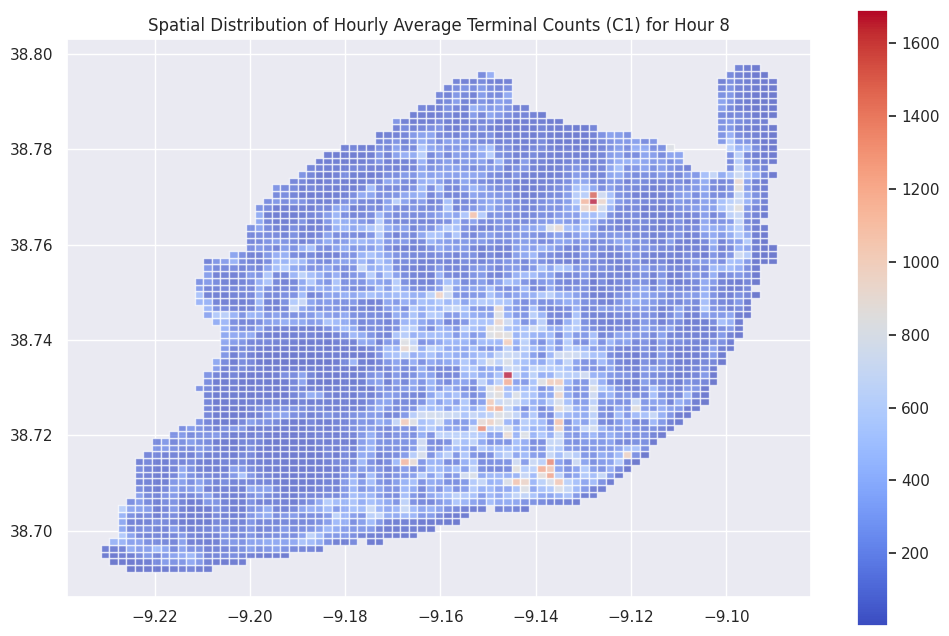

### **TODO** ⚙️Modelling - Performance

Example of train and validation set loss - mean squared error - during training

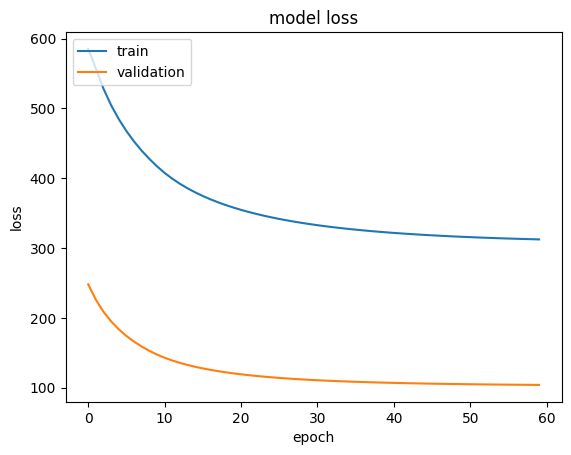

Predictions at timestamp: current time (t) + X minute (left) VS real values (right). Lighter areas indicate higher population density.

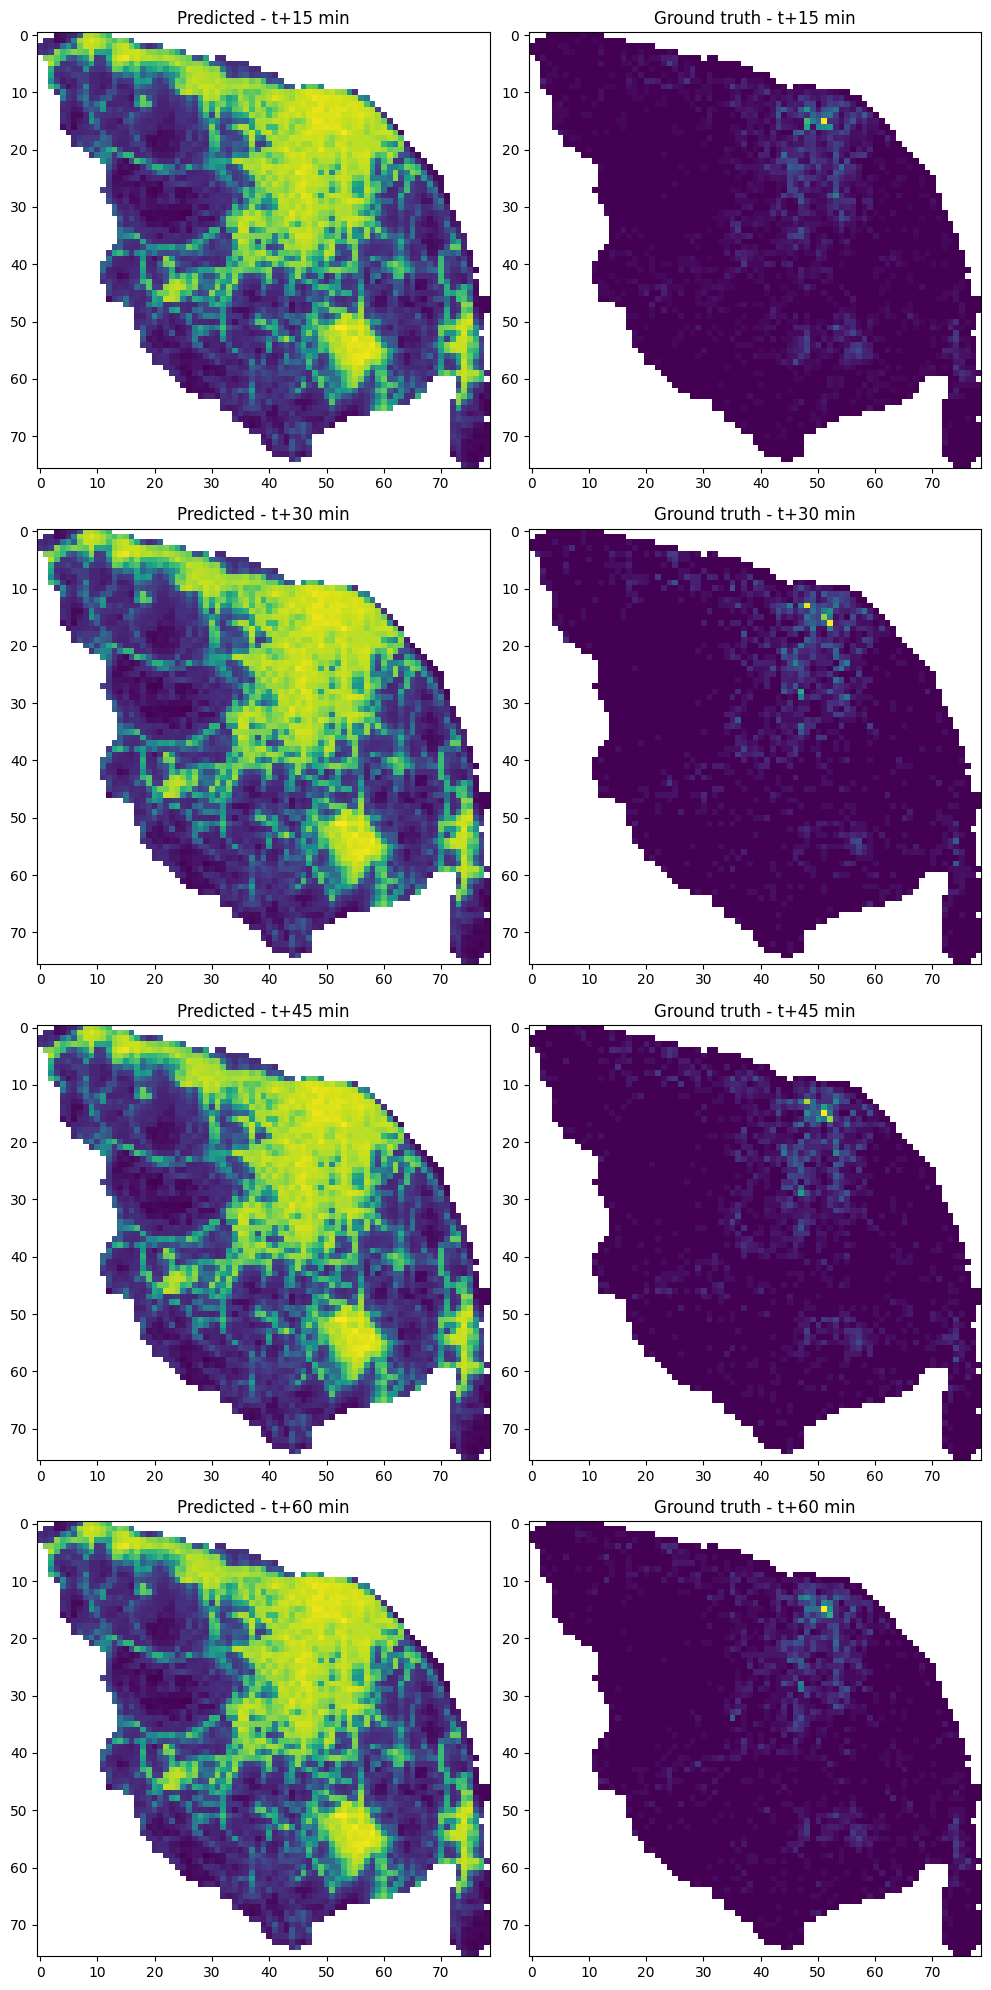

Although still not too accurate as the learning time was limited and the architecture small, this shows the potential for future improvement.

### **TODO** 🚇 Train Station Dataset - Exploratory Analysis

Train stations

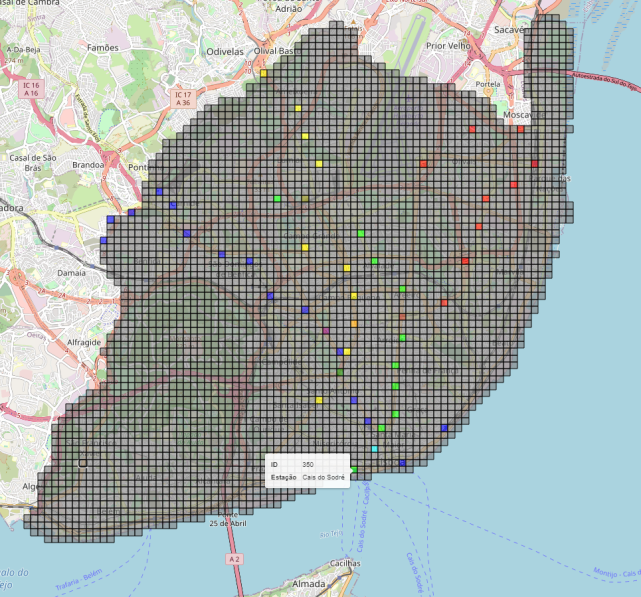

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

[1] city of Lisbon population in 2023 - https://www.macrotrends.net/cities/22167/lisbon/population#:~:text=The%20current%20metro%20area%20population,a%200.51%25%20increase%20from%202020. - last accessed 18/04/2023

[2] CNN-LSTM model - https://github.com/Pradnya1208/Time-series-forecasting-using-Deep-Learning  - last accessed 18/04/2023

[3] learning rate scheduler - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler  - last accessed 18/04/2023


## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.


# Climate data
This code loads the `climetlab` package and sets the source and dataset to retrieve data from the Climate Data Store (CDS) for the ERA5 reanalysis dataset. The API configuration was performed following `https://cds.climate.copernicus.eu/api-how-to`.

`climetlab.load_source` ->  The `product_type` is set to `"reanalysis"`, and the `variable` is set to `"2m_temperature"` to retrieve temperature data at 2 meters above ground level (Kelvin), or `"total_precipitation"` represents the total precipitation rate and its units are meters per second (m s-1)
  The `year` is set to `2022`, and the `month` is set to a list containing `9`, `10`, and `11` to retrieve data for September, October, and November of 2022.
   The `day` and `time` are set to `"01"` and `"12:00"`, respectively, to retrieve data for the first day of each month at noon.
    The `area` parameter is set to `[38.72, -9.14, 38.72, -9.14]` to specify the coordinates for Lisbon.
    The data is then loaded into an xarray object using the `to_xarray()` method and printed to the screen.
    Is there anything else you would like to know?

In [ ]:
import climetlab as cml
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
hours_param = [f"0{i}:00" for i in range(0, 10)] + [f"{i}:00" for i in range(10, 24)]

In [ ]:
# Set the source and dataset
source = cml.load_source("cds", "reanalysis-era5-single-levels",
                         product_type="reanalysis",
                         variable="2m_temperature",
                         year=2022,
                         month=[9, 10, 11],
                         day=list(range(1,31)),
                         time=hours_param,
                         area=[38.72, -9.14, 38.72, -9.14])

# Load the data
data_temp = source.to_xarray()

In [ ]:
# total_precipitation represents the total precipitation rate and its units are meters per second (m s-1)
source = cml.load_source("cds", "reanalysis-era5-single-levels",
                         product_type="reanalysis",
                         variable="total_precipitation",
                         year=2022,
                         month=[9,10,11],
                         day=list(range(1,31)),
                         time=hours_param,
                         area=[38.72, -9.14, 38.72, -9.14])

# Load the data
data_precip = source.to_xarray()

In [ ]:
# Convert the merged xarray object to a pandas DataFrame
df = data_temp.to_dataframe().reset_index()
df['tp'] =  data_precip.to_dataframe().reset_index()['tp']
# Set the time column as the index
df = df.set_index("time")

In [ ]:
df

,number,step,surface,latitude,longitude,valid_time,t2m,tp
time,,,,,,,,
2022-09-01 00:00:00,0,0 days,0.0,38.72,-9.14,2022-09-01 00:00:00,291.621094,NaN
2022-09-01 01:00:00,0,0 days,0.0,38.72,-9.14,2022-09-01 01:00:00,291.286133,NaN
2022-09-01 02:00:00,0,0 days,0.0,38.72,-9.14,2022-09-01 02:00:00,290.988037,NaN
2022-09-01 03:00:00,0,0 days,0.0,38.72,-9.14,2022-09-01 03:00:00,290.770264,NaN
2022-09-01 04:00:00,0,0 days,0.0,38.72,-9.14,2022-09-01 04:00:00,290.410400,NaN
...,...,...,...,...,...,...,...,...
2022-11-30 19:00:00,0,0 days,0.0,38.72,-9.14,2022-11-30 19:00:00,287.555908,0.000000e+00
2022-11-30 20:00:00,0,0 days,0.0,38.72,-9.14,2022-11-30 20:00:00,287.107422,0.000000e+00
2022-11-30 21:00:00,0,0 days,0.0,38.72,-9.14,2022-11-30 21:00:00,286.808350,5.734568e-08


In [ ]:
df_resampled = df.resample("5D").mean()
# Format the timestamps as strings with only the day and month
df_resampled.index = df_resampled.index.strftime("%d-%m")

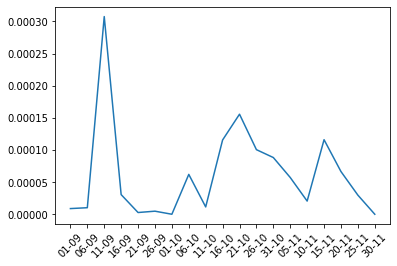

In [ ]:
# Visualize flood in december
plt.plot(df_resampled.index, df_resampled['tp'])
plt.xticks(rotation=45)
plt.show()

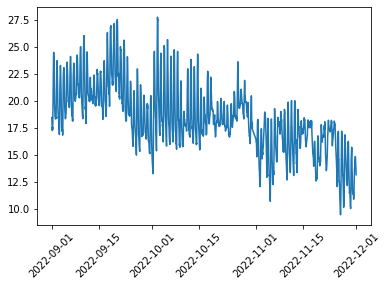

In [ ]:
plt.plot(df.index, df['t2m']-273.15)
plt.xticks(rotation=45)
plt.show()

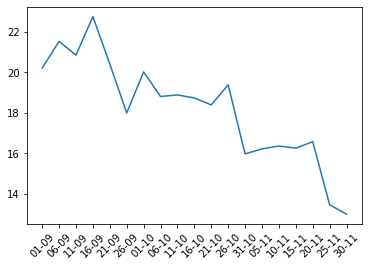

In [ ]:
plt.plot(df_resampled.index, df_resampled['t2m']-273.15)
plt.xticks(rotation=45)
plt.show()